## Шаг 0: Зависимости

In [542]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, fbeta_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [543]:
torch.manual_seed(42)  # Настройка воспроизводимости
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Шаг 1: Загрузка данных

In [544]:
# # Загрузка всех таблиц
# telemetry = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_telemetry.csv")
# errors = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_errors.csv")
# maint = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_maint.csv")
# failures = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_failures.csv")
# machines = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_machines.csv")

In [545]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [546]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [547]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [548]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


errorID
error1    1010
error2     988
error3     838
error4     727
error5     356
Name: count, dtype: int64

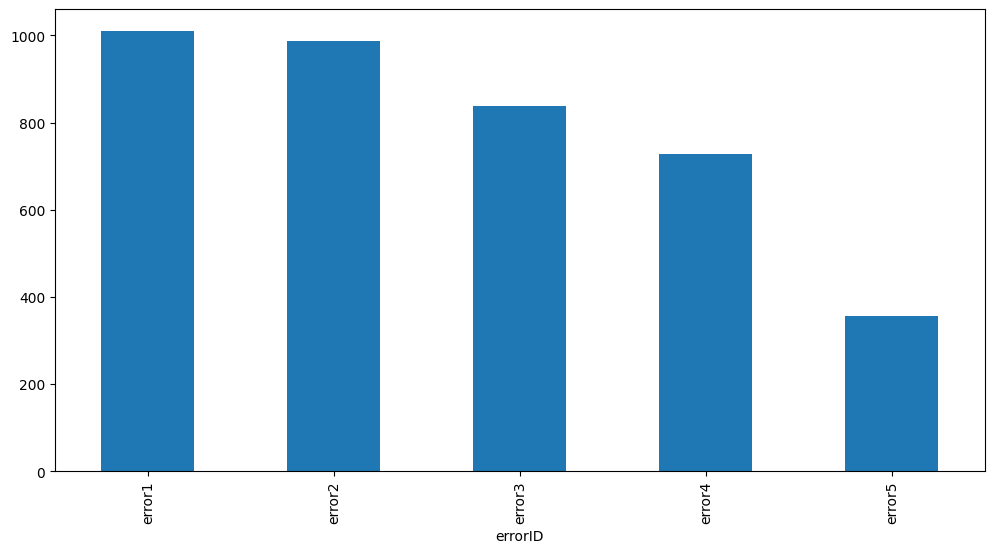

In [549]:
plt.figure(figsize=(12, 6))
errors["errorID"].value_counts().plot(kind="bar")
errors["errorID"].value_counts()

In [550]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64

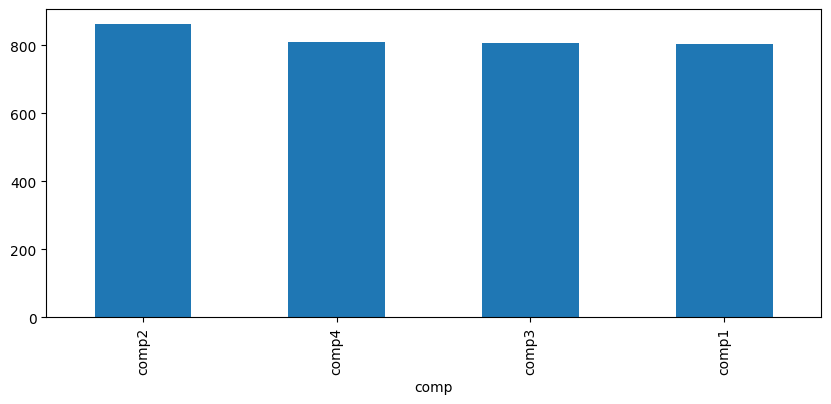

In [551]:
plt.figure(figsize=(10, 4))
maint["comp"].value_counts().plot(kind="bar")
maint["comp"].value_counts()

In [552]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


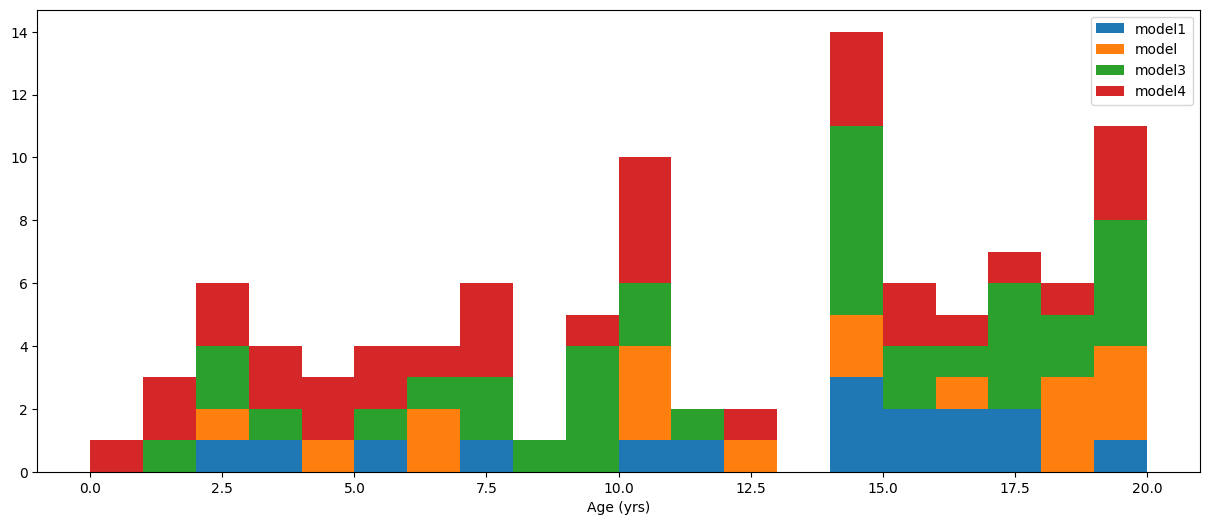

In [553]:
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines["model"] == "model1", "age"],
                       machines.loc[machines["model"] == "model2", "age"],
                       machines.loc[machines["model"] == "model3", "age"],
                       machines.loc[machines["model"] == "model4", "age"]],
                       20, stacked=True, label=["model1", "model", "model3", "model4"])
plt.xlabel("Age (yrs)")
plt.legend()

In [554]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

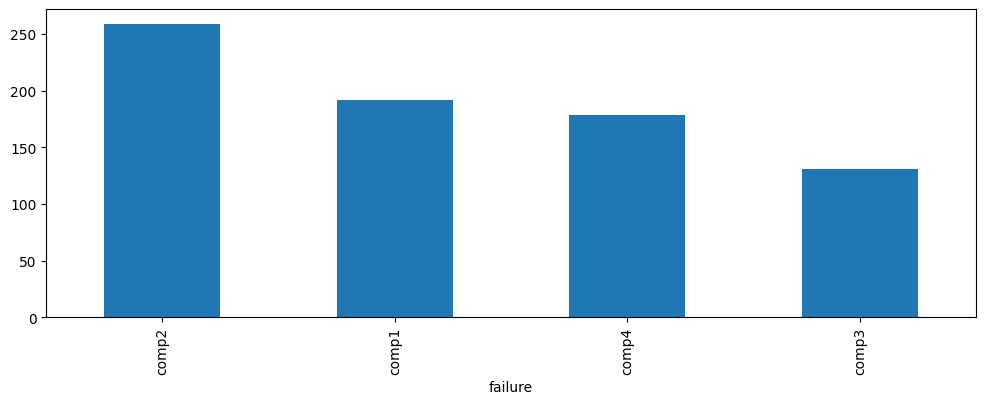

In [555]:
plt.figure(figsize=(12, 4))
failures["failure"].value_counts().plot(kind="bar")
failures["failure"].value_counts()

## Шаг 2: Feature Engineering

Примечание: 

Этот датасет не содержит пропусков, поэтому этап импутации (LSTM encoder-decoder) можно опустить. Временные окна есть.

Скользящие средние и STD (3h и 24h).

In [556]:
# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

def create_telemetry_features(telemetry):
    telemetry = telemetry.sort_values(["machineID", "datetime"])
    telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")
    
    # 3h aggregates
    agg_3h = telemetry.groupby(["machineID", "datetime_3h"])[fields].agg(["mean", "std"]).reset_index()
    agg_3h.columns = ["machineID", "datetime"] + [f"{f}{s}_3h" for f in fields for s in ["mean", "sd"]]
    
    # 24h rolling (на основе часовых данных)
    telemetry_wide = telemetry.set_index("datetime")
    agg_24h_list = []
    for mid, group in telemetry_wide.groupby("machineID"):
        for f in fields:
            group[f + "mean_24h"] = group[f].rolling("24H", min_periods=1).mean()
            group[f + "sd_24h"] = group[f].rolling("24H", min_periods=1).std()
        agg_24h_list.append(group[["machineID"] + [f + "mean_24h" for f in fields] + [f + "sd_24h" for f in fields]].reset_index())
    
    agg_24h = pd.concat(agg_24h_list, ignore_index=True)
    agg_24h = agg_24h.dropna()
    
    # Объединение
    feat = agg_3h.merge(agg_24h, on=["machineID", "datetime"], how="inner")
    return feat

Исследуем различные методы сглаживания для одного телеметрического признака.

In [557]:
# Выбираем машину и период
machine_id = 1
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2015-02-01")

plot_df = telemetry.loc[
    (telemetry["machineID"] == machine_id) &
    (telemetry["datetime"] >= start_date) &
    (telemetry["datetime"] <= end_date)
].copy().sort_values("datetime")

print(f"Data: {len(plot_df)} dots (hr)")

Data: 739 dots (hr)


In [558]:
# Скользящее среднее и STD за 24 часа
plot_df = plot_df.set_index("datetime")
plot_df["volt_rolling_mean"] = plot_df["volt"].rolling(window=24, min_periods=1).mean()
plot_df["volt_rolling_std"] = plot_df["volt"].rolling(window=24, min_periods=1).std()
plot_df = plot_df.reset_index()

In [559]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Применяем Holt-Winters с аддитивным трендом и сезонностью
hw_model = ExponentialSmoothing(
    plot_df["volt"],
    trend="add",
    seasonal="add",
    seasonal_periods=24  # Дневная сезонность (24 часа)
).fit()

plot_df["volt_holt_winters"] = hw_model.fittedvalues

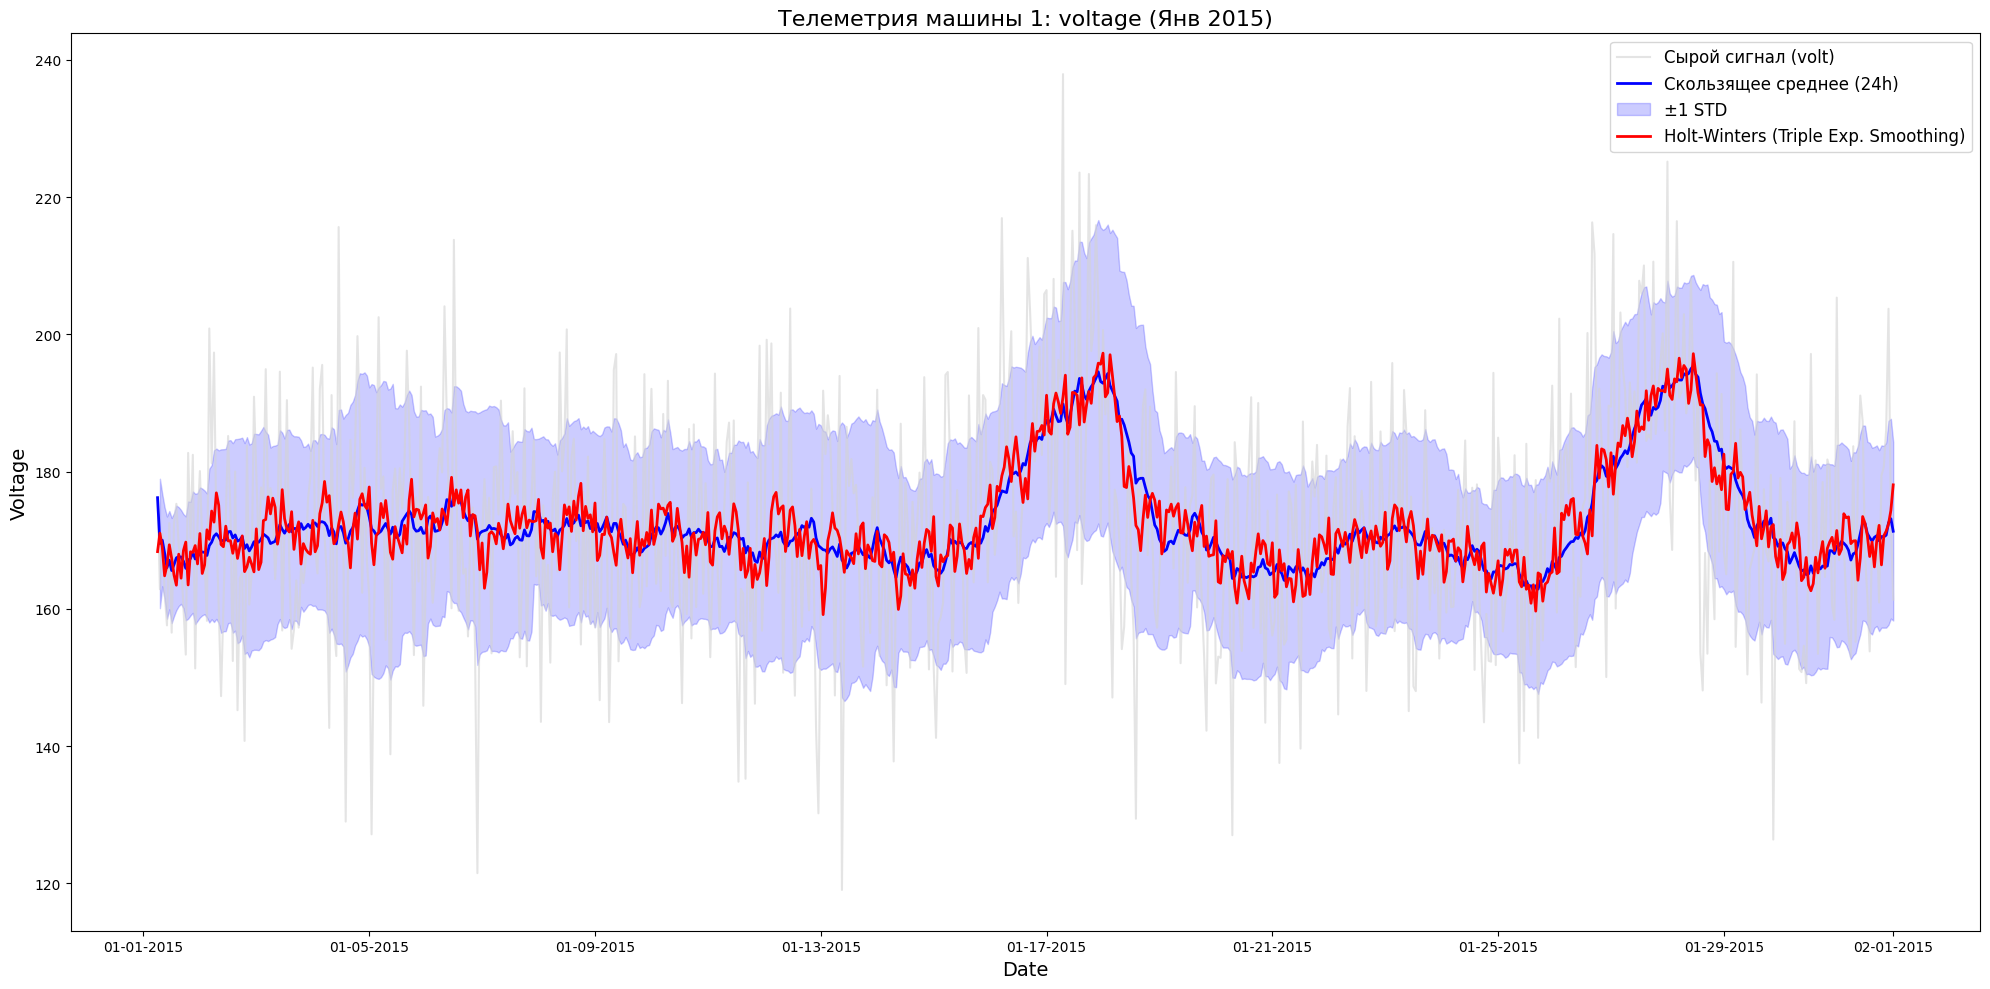

In [560]:
plt.figure(figsize=(20, 10))

# Исходные данные
plt.plot(plot_df["datetime"], plot_df["volt"], 
         label="Сырой сигнал (volt)", 
         alpha=0.6, color="lightgray")

# Скользящее среднее
plt.plot(plot_df["datetime"], plot_df["volt_rolling_mean"], 
         label="Скользящее среднее (24h)", 
         color="blue", linewidth=2)

# Доверительный интервал на основе STD
plt.fill_between(
    plot_df["datetime"],
    plot_df["volt_rolling_mean"] - plot_df["volt_rolling_std"],
    plot_df["volt_rolling_mean"] + plot_df["volt_rolling_std"],
    color="blue", alpha=0.2, label="±1 STD"
)

# Holt-Winters
plt.plot(plot_df["datetime"], plot_df["volt_holt_winters"], 
         label="Holt-Winters (Triple Exp. Smoothing)", 
         color="red", linewidth=2)

# Настройки
plt.title(f"Телеметрия машины {machine_id}: voltage (Янв 2015)", fontsize=16)
plt.ylabel("Voltage", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend(fontsize=12)

# Формат даты на оси X
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m-%d-%Y"

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Residuals Holt-Winters')

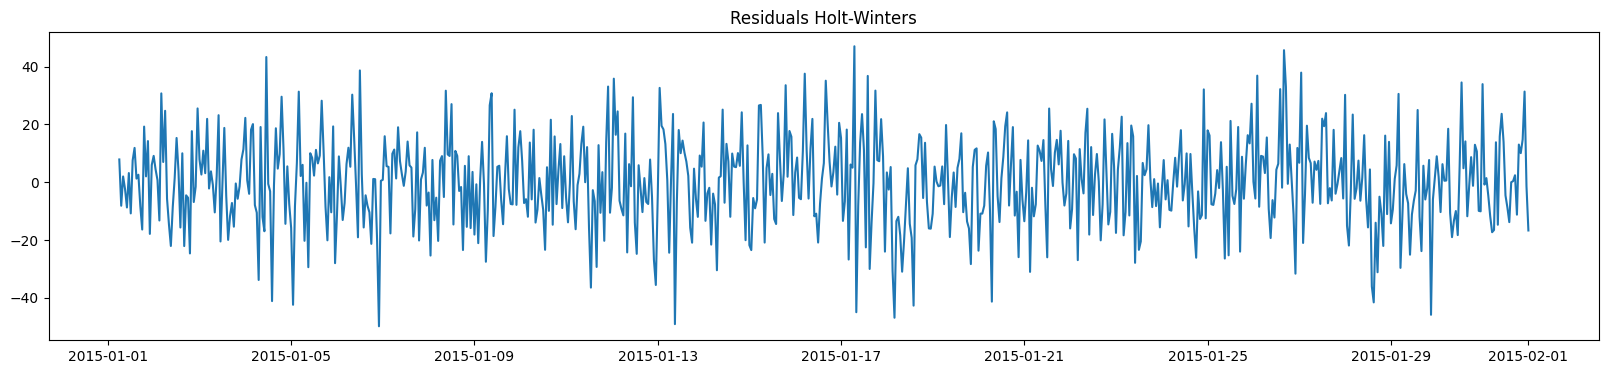

In [561]:
residuals = plot_df["volt"] - plot_df["volt_holt_winters"]  # Остатки

plt.figure(figsize=(20, 4))
plt.plot(plot_df["datetime"], residuals)
plt.title("Residuals Holt-Winters")

In [562]:
# Объединение всех признаков
telemetry_feat = create_telemetry_features(telemetry)

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,170.776977,446.605840,100.858037,40.384634,14.916891,49.947114,10.046691,5.002247
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,154.022949,266.010419,84.563174,31.883282,2.495533,12.026460,1.619279,0.896217
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,168.070558,441.539601,98.667943,39.353304,13.356554,44.663514,8.923512,4.460112
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,170.211969,449.210851,100.098210,40.072717,14.852678,49.612699,9.921354,4.958619
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,172.462699,456.369633,101.613240,40.833986,16.394477,54.825097,10.981117,5.485186
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,220.782618,513.761534,152.310351,61.932124,32.696413,121.544102,28.654103,13.203534
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,4.728555,18.095457,4.744648,2.062891,2.265301,7.699836,1.716655,0.801680


In [563]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-01 09:00:00,164.192565,7.596570,403.949857,50.120452,105.687417,8.555032,34.255891,7.662229,168.137453,423.687682,98.256232,40.950662,6.665324,75.770259,17.109194,4.798255
1,1,2015-01-01 12:00:00,168.134445,10.124584,435.781707,55.084734,107.793709,5.909721,41.239405,5.169304,165.602958,437.074655,101.799186,38.314585,7.663161,60.321814,13.926919,6.776542
2,1,2015-01-01 15:00:00,165.514453,4.673269,430.472823,42.047278,101.703289,4.554047,40.373739,2.106108,167.628643,432.864675,102.906797,38.906813,7.201655,52.122115,11.734582,6.091345
3,1,2015-01-01 18:00:00,168.809347,14.752132,437.111120,47.048609,90.911060,4.244158,41.738542,2.207884,165.920374,434.606729,101.180158,39.568936,7.567359,50.433677,11.284286,5.550047
4,1,2015-01-01 21:00:00,168.779396,15.901952,486.242664,36.129552,90.446472,4.310741,41.796657,9.390494,168.281657,435.779180,99.239088,40.407795,8.847319,49.216633,11.038620,5.731789


Добавление Trend Features.

In [564]:
# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

Добавление FFT Features.

In [565]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

In [566]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Нормализация FFT-признаков
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

 Это гарантирует, что FFT-признаки имеют среднее ≈ 0 и std ≈ 1, как и исходные признаки (mean_3h, sd_24h и т.д.).

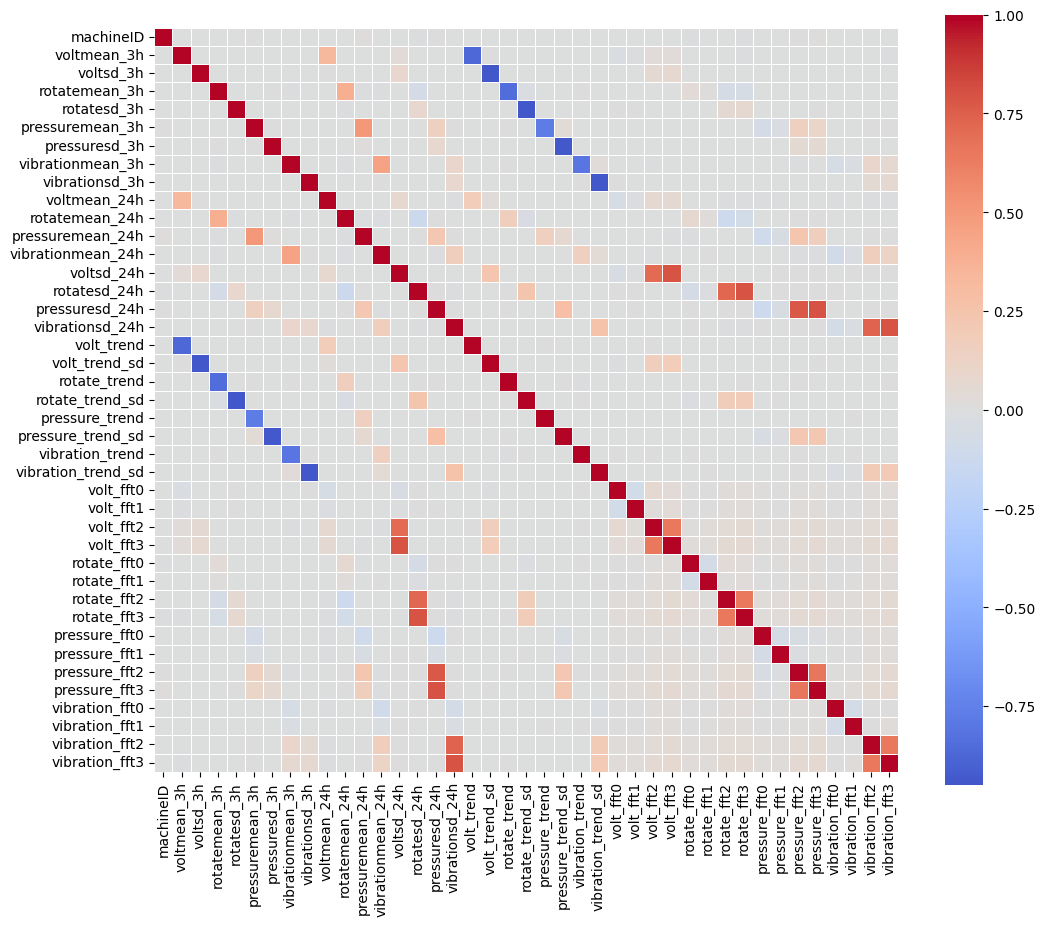

In [567]:
# Визуализация корреляции (для отладки)
plt.figure(figsize=(12, 10))
sns.heatmap(telemetry_feat.select_dtypes(include=[np.number]).corr(), 
            cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.show()

Признаки действительно слабо коррелируют, так как telemetry_feat включает разные физические величины. Но проверить стоило. 

Создаем подсчет ошибок за последние 24h.

In [568]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,195400.000000,195400,195400.000000,195400.000000,195400.000000,195400.000000,195400.000000
mean,50.500000,2015-07-02 11:45:32.241555712,0.041351,0.040409,0.034186,0.029724,0.014575
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-03-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-01 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000
std,28.866144,NaN,0.202971,0.200702,0.184835,0.171951,0.120823


In [569]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
6,1,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0


Вычисляем дни с последней замены для каждого компонента.

In [570]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [571]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


In [572]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 'model'
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,...,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,...,0.027670,0.027044,0.022867,0.019887,0.009753,53.469000,51.477503,52.664745,53.772467,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,...,0.167172,0.165286,0.152026,0.141344,0.099075,62.484891,59.255134,58.862269,59.697678,5.827625


In [573]:
final_feat.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
0,1,2015-01-01 09:00:00,164.192565,7.596570,403.949857,50.120452,105.687417,8.555032,34.255891,7.662229,...,0.0,19.125,214.125,154.125,169.125,18,False,False,True,False
1,1,2015-01-01 12:00:00,168.134445,10.124584,435.781707,55.084734,107.793709,5.909721,41.239405,5.169304,...,0.0,19.250,214.250,154.250,169.250,18,False,False,True,False
2,1,2015-01-01 15:00:00,165.514453,4.673269,430.472823,42.047278,101.703289,4.554047,40.373739,2.106108,...,0.0,19.375,214.375,154.375,169.375,18,False,False,True,False
3,1,2015-01-01 18:00:00,168.809347,14.752132,437.111120,47.048609,90.911060,4.244158,41.738542,2.207884,...,0.0,19.500,214.500,154.500,169.500,18,False,False,True,False
4,1,2015-01-01 21:00:00,168.779396,15.901952,486.242664,36.129552,90.446472,4.310741,41.796657,9.390494,...,0.0,19.625,214.625,154.625,169.625,18,False,False,True,False


In [574]:
# Сортировка и объединение отказов с признаками по времени
failures["datetime"] = pd.to_datetime(failures["datetime"])
failures = failures.sort_values(["machineID", "datetime"])

# Список всех отказов
failure_records = []

for _, row in failures.iterrows():
    mid = row["machineID"]
    t_fail = row["datetime"]
    comp = row["failure"]
    
    # Выбираем признаки за 24 часа до отказа
    window_start = t_fail - pd.Timedelta(hours=24)
    window_features = final_feat[
        (final_feat["machineID"] == mid) &
        (final_feat["datetime"] >= window_start) &
        (final_feat["datetime"] < t_fail)
    ].copy()
    
    # Каждая строка в окне отдельный объект с меткой отказа
    window_features["failure"] = comp
    failure_records.append(window_features)

# Объединяем все положительные окна
positive_samples = pd.concat(failure_records, ignore_index=True)

# Добавляем случайные отрицательные примеры без отказа
# Сначала определим все временные точки, где нет отказа в будущем 24h
all_times = final_feat[["machineID", "datetime"]].copy()
all_times = all_times.merge(failures, on=["machineID", "datetime"], how="left")
all_times = all_times[all_times["failure"].isna()]  # Нет отказа именно в этот момент

# Убираем точки, где в следующие 24h есть отказ
def has_failure_in_next_24h(row, failures_df):
    t = row["datetime"]
    mid = row["machineID"]
    future_fails = failures_df[
        (failures_df["machineID"] == mid) &
        (failures_df["datetime"] > t) &
        (failures_df["datetime"] <= t + pd.Timedelta(hours=24))
    ]
    return not future_fails.empty

all_times["has_future_fail"] = all_times.apply(
    lambda r: has_failure_in_next_24h(r, failures), axis=1
)
negative_candidates = all_times[~all_times["has_future_fail"]]

# Выбираем случайные точки 
# Например, в 10 раза больше, чем положительных
n_pos = len(positive_samples)
n_neg = min(10 * n_pos, len(negative_candidates))
negative_samples = negative_candidates.sample(n=n_neg, random_state=42).copy()
negative_samples = negative_samples.merge(final_feat, on=["machineID", "datetime"], how="left")
negative_samples["failure"] = "none"

# Объединяем
labeled_features_clean = pd.concat([positive_samples, negative_samples], ignore_index=True)
labeled_features = labeled_features_clean.dropna(subset=["failure"])
labeled_features.head()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4,failure,has_future_fail
0,1,2015-01-04 06:00:00,166.281848,24.276228,453.787824,23.621315,106.187582,11.176731,51.990080,3.394073,...,217.000,157.000,172.000,18,False,False,True,False,comp4,NaN
1,1,2015-01-04 09:00:00,175.412103,34.918687,445.450581,11.001625,100.887363,10.580336,54.251534,2.921501,...,217.125,157.125,172.125,18,False,False,True,False,comp4,NaN
2,1,2015-01-04 12:00:00,157.347716,24.617739,451.882075,28.950883,101.289380,9.966729,48.602686,2.356486,...,217.250,157.250,172.250,18,False,False,True,False,comp4,NaN
3,1,2015-01-04 15:00:00,176.450550,8.071400,446.033068,76.511343,84.521555,2.636879,47.638836,4.108621,...,217.375,157.375,172.375,18,False,False,True,False,comp4,NaN
4,1,2015-01-04 18:00:00,190.325814,8.390777,422.692565,7.176553,107.393234,4.262645,49.552856,7.598552,...,217.500,157.500,172.500,18,False,False,True,False,comp4,NaN


In [575]:
print("Positive samples (failures):", len(positive_samples))
print("Negative samples (none):", len(negative_samples))

Positive samples (failures): 6049
Negative samples (none): 60490


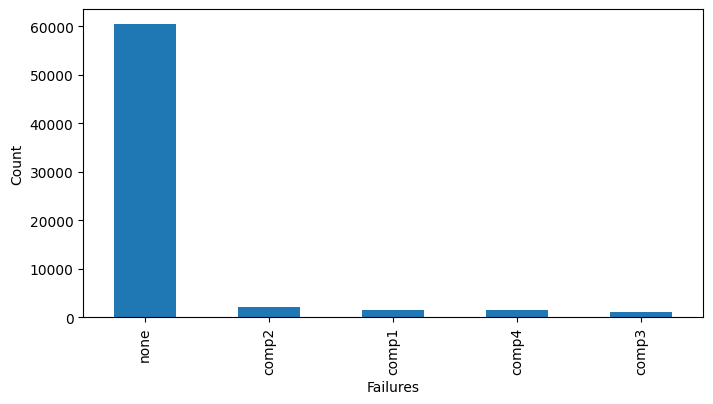

In [576]:
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar")  # Визуализация дисбаланса
plt.xlabel("Failures")
plt.ylabel("Count")
plt.show()

Произведем Undersampling превалирующего класса.

In [577]:
# После объединения
class_counts = labeled_features["failure"].value_counts()
max_minority = class_counts.drop("none").max()

# Оставляем не более 3× от самого частого отказа
undersample_none = labeled_features[
    (labeled_features["failure"] != "none") |
    (labeled_features["failure"] == "none") &
    (labeled_features.groupby("failure").cumcount() < 3.0 * max_minority)
]
labeled_features = undersample_none

## Шаг 3: Глобальный временной сплит

Примечание (временные ряды): 

Данные обладают **внутренней хронологической зависимостью**: будущее зависит от прошлого, но прошлое не зависит от будущего.

In [578]:
# from sklearn.model_selection import train_test_split

# # Найдём для каждой машины её основной тип отказа 
# machine_failure_types = labeled_features.groupby("machineID")["failure"].apply(
#     lambda x: x[x != "none"].iloc[0] if len(x[x != "none"]) > 0 else "none"
# ).reset_index()
# machine_failure_types.columns = ["machineID", "primary_failure"]

# # Уникальные machineID с их целевыми классами
# mids = machine_failure_types["machineID"].values
# targets = machine_failure_types["primary_failure"].values

# # Stratified split по машинам
# train_mids, val_mids = train_test_split(
#     mids, 
#     test_size=0.2, 
#     stratify=targets,  
#     random_state=42
# )

# train_mask = labeled_features["machineID"].isin(train_mids)
# val_mask = labeled_features["machineID"].isin(val_mids)

# Глобальный временной сплит
split_time = labeled_features["datetime"].quantile(0.8)
train_mask = labeled_features["datetime"] < split_time
val_mask = labeled_features["datetime"] >= split_time

# # Импорты и Walk-Forward CV
from sklearn.model_selection import ParameterGrid
import copy

# def walk_forward_splits_clf(df, n_splits=5, min_train_ratio=0.3):
#     df = df.sort_values("datetime").reset_index(drop=True)
#     n = len(df)
#     min_train_size = int(n * min_train_ratio)
#     step = (n - min_train_size) // n_splits
#     splits = []
#     for i in range(n_splits):
#         train_end = min_train_size + i * step
#         if train_end >= n: break
#         val_end = min(train_end + step, n)
#         train_idx = df.index[:train_end]
#         val_idx = df.index[train_end:val_end]
#         splits.append((train_idx, val_idx))
#     return splits

# # Создаём датафрейм для классификации
# clf_df = labeled_features.copy().reset_index(drop=True)
# splits_clf = walk_forward_splits_clf(clf_df, n_splits=3, min_train_ratio=0.4)

## Шаг 4: Построение бинарной метки (за 24h до отказа)

In [579]:
from sklearn.preprocessing import LabelEncoder

# Признаки и метки
X = labeled_features.drop(columns=["datetime", "machineID", "failure"])
y = labeled_features["failure"]

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# One-hot кодирование оставшихся категориальных колонок
X = pd.get_dummies(X, drop_first=False)  # drop_first=False сохраняем все категории

# Train/val
X_train = X.loc[train_mask].values.astype(np.float32)
y_train = y_encoded[train_mask].astype(np.int64)

X_val = X.loc[val_mask].values.astype(np.float32)
y_val = y_encoded[val_mask].astype(np.int64)

In [580]:
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nVal class distribution:")
print(pd.Series(y_val).value_counts().sort_index())

Train class distribution:
0    1244
1    1631
2     849
3    1159
4    4914
Name: count, dtype: int64

Val class distribution:
0     272
1     435
2     192
3     267
4    1284
Name: count, dtype: int64


В временных рядах SMOTE/Oversampling не рекомендуется, так как генерирует «неправдоподобные» точки во времени. 

In [581]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# print(f"Before oversampling: classes = {np.bincount(y_train)}")
# print(f"After oversampling: classes = {np.bincount(y_train_bal)}")

## Шаг 6: Нормализация и тензоры

In [582]:
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_val_scaled = scaler_clf.transform(X_val)

# Тензоры для классификации 
X_train_clf_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_clf_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_clf_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_clf_t = torch.tensor(y_val, dtype=torch.long).to(device)

# Создание DataLoader
train_loader_clf = DataLoader(TensorDataset(X_train_clf_t, y_train_clf_t), batch_size=256, shuffle=False)
val_loader_clf = DataLoader(TensorDataset(X_val_clf_t, y_val_clf_t), batch_size=256, shuffle=False)

input_size = X_train.shape[1]
n_classes = 5

## Шаг 7: Модели

Калибровка вероятностей.

In [583]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TorchClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self, model, n_classes=5):
        self.model = model
        self.n_classes = n_classes
        self.model.eval()
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            out = self.model(X_tensor)
            prob = torch.softmax(out, dim=1).cpu().numpy() 
        return prob
    
    def predict(self, X):
        prob = self.predict_proba(X)
        return np.argmax(prob, axis=1)

Мультиклассовая Focal Loss.

In [584]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)  # (N, C), (N,)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        else:
            return focal_loss

Focal Loss часто повышает precision, так как гасит переобучение на лёгких примерах отказов.

Общий класс для классификации и регрессии.

In [585]:
class DLinear(nn.Module):
    def __init__(self, input_size, n_classes=5, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Веса для seasonal и trend компонент
        output_dim = n_classes
        self.linear_seasonal = nn.Linear(input_size, output_dim)
        self.linear_trend = nn.Linear(input_size, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        out = self.linear_seasonal(x) + self.linear_trend(x)
        return out  # (B, n_classes)

В DLinear нет скрытых слоёв, поэтому dropout применяется к входным признакам, что снижает зависимость от ложных корреляций.

In [586]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, n_classes=5, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.proj = nn.Linear(input_size, hidden_size)
        
        # TransformerEncoderLayer включает dropout 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=128,
            dropout=dropout,      # Регуляризация внимания и FFN
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)  # Дополнительный dropout перед классификатором
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.proj(x)               # (B, hidden_size)
        x = x.unsqueeze(1)             # (B, 1, hidden_size)
        x = self.transformer(x)        # (B, 1, hidden_size)
        x = x[:, 0, :]                 # (B, hidden_size)
        x = self.dropout(x)            # Регуляризация выхода
        return self.fc(x)

In [587]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_size)
        _, (h, _) = self.lstm(x)  # h: (1, B, hidden_size)
        h_last = self.dropout(h[-1])  # (B, hidden_size)
        out = self.fc(h_last) 
        return out  # (B, n_classes)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, h = self.gru(x)
        h_last = self.dropout(h[-1])
        out = self.fc(h_last) 
        return out

Обучение (единый цикл).

In [588]:
class ValueMeter(object):
    """
    Вспомогательный класс, чтобы отслеживать loss и метрику
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.total = 0

    def add(self, value, n=1):
        self.sum += value * n
        self.total += n

    def value(self):
        return self.sum / self.total if self.total > 0 else float('nan')

def log(mode, epoch, loss_meter, f1_meter):
    """
    Логирует loss и accuracy 
    """
    print(
        f'[{mode}] Epoch: {epoch+1:02d}. '
        f'Loss: {loss_meter.value():.4f}. '
        f'F1: {100 * f1_meter.value():.2f}%'
    )

In [589]:
def Evaluate(model, train_loader, val_loader, epochs=200, y_train=None):
    device = next(model.parameters()).device
    best_val_score = -float('inf')  # Будет F1 (max) или -MAE (max при инверсии)
    patience = 15
    counter = 0
    best_model_state = copy.deepcopy(model.state_dict())

    # Определение loss
    class_counts = np.bincount(y_train)
    alpha = 1.0 / class_counts
    alpha = alpha / alpha.sum() * len(class_counts)  # Нормализация 
    alpha = torch.FloatTensor(alpha).to(device)
    criterion = criterion = FocalLoss(alpha=alpha, gamma=1.0, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

    # История
    train_losses, val_losses = [], []
    train_scores, val_scores = [], []

    for epoch in range(epochs):
        # Обучение 
        model.train()
        train_loss_meter = ValueMeter()
        all_preds, all_trues = [], []

        for X, y in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Градиентное клиппирование
            optimizer.step()
            train_loss_meter.add(loss.item(), X.size(0))

            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_trues.append(y.cpu().numpy())

        # Метрика на трейне
        all_preds = np.concatenate(all_preds)
        all_trues = np.concatenate(all_trues)
        train_score = f1_score(all_trues, all_preds, average='macro', zero_division=0)

        train_scores.append(train_score)
        train_losses.append(train_loss_meter.value())

        # Логирование
        f1_meter_train = ValueMeter()
        f1_meter_train.add(train_score)

        # Валидация 
        model.eval()
        val_loss_meter = ValueMeter()
        all_val_preds, all_val_trues = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss_meter.add(loss.item(), X.size(0))

                preds = out.argmax(dim=1)
                all_val_preds.append(preds.cpu().numpy())
                all_val_trues.append(y.cpu().numpy())

        # Метрика на валидации
        all_val_preds = np.concatenate(all_val_preds)
        all_val_trues = np.concatenate(all_val_trues)
        val_score = f1_score(all_val_trues, all_val_preds, average='macro', zero_division=0)
        val_scores.append(val_score)
        val_losses.append(val_loss_meter.value())

        f1_meter_val = ValueMeter()
        f1_meter_val.add(val_score)

        print(f"[Multi] Epoch {epoch+1}. Train F1: {f1_meter_train.value():.2f}, Val F1: {f1_meter_val.value():.2f}")

        # Early Stopping 
        if val_score > best_val_score:
            best_val_score = val_score
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping on epoch {epoch+1}")
                break

    # Загрузка лучшей модели
    model.load_state_dict(best_model_state)
    model.eval()

    # Финальное предсказание
    preds = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            out = model(X)
            prob = torch.softmax(out, dim=1).cpu().numpy()
            preds.append(prob) 
    preds = np.concatenate(preds, axis=0)

    return preds, {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_score": train_scores,
        "val_score": val_scores,
        "best_val_score": best_val_score
    }

## Шаг 8: Классификация

In [590]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")  # (Baseline)
dummy.fit(X_train_clf_t, y_train_clf_t)

print("Dummy Val F1:", f1_score(y_val_clf_t, dummy.predict(X_val_clf_t), average="macro"))

Dummy Val F1: 0.19553167133191346


In [591]:
# Модель
lstm_model = LSTMModel(input_size, hidden_size=128, n_classes=5, dropout=0.6).to(device)

# Обучение
y_score, history = Evaluate(lstm_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_lstm = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 39/39 [00:00<00:00, 283.92it/s]


[Multi] Epoch 1. Train F1: 0.15, Val F1: 0.24


Train 2/200: 100%|██████████| 39/39 [00:00<00:00, 536.47it/s]


[Multi] Epoch 2. Train F1: 0.28, Val F1: 0.41


Train 3/200: 100%|██████████| 39/39 [00:00<00:00, 487.21it/s]


[Multi] Epoch 3. Train F1: 0.41, Val F1: 0.49


Train 4/200: 100%|██████████| 39/39 [00:00<00:00, 520.66it/s]


[Multi] Epoch 4. Train F1: 0.50, Val F1: 0.55


Train 5/200: 100%|██████████| 39/39 [00:00<00:00, 564.06it/s]


[Multi] Epoch 5. Train F1: 0.55, Val F1: 0.60


Train 6/200: 100%|██████████| 39/39 [00:00<00:00, 550.16it/s]


[Multi] Epoch 6. Train F1: 0.60, Val F1: 0.65


Train 7/200: 100%|██████████| 39/39 [00:00<00:00, 547.82it/s]


[Multi] Epoch 7. Train F1: 0.64, Val F1: 0.68


Train 8/200: 100%|██████████| 39/39 [00:00<00:00, 546.84it/s]


[Multi] Epoch 8. Train F1: 0.68, Val F1: 0.71


Train 9/200: 100%|██████████| 39/39 [00:00<00:00, 557.72it/s]


[Multi] Epoch 9. Train F1: 0.71, Val F1: 0.73


Train 10/200: 100%|██████████| 39/39 [00:00<00:00, 560.53it/s]


[Multi] Epoch 10. Train F1: 0.73, Val F1: 0.75


Train 11/200: 100%|██████████| 39/39 [00:00<00:00, 567.40it/s]


[Multi] Epoch 11. Train F1: 0.75, Val F1: 0.78


Train 12/200: 100%|██████████| 39/39 [00:00<00:00, 564.64it/s]


[Multi] Epoch 12. Train F1: 0.77, Val F1: 0.80


Train 13/200: 100%|██████████| 39/39 [00:00<00:00, 538.94it/s]


[Multi] Epoch 13. Train F1: 0.79, Val F1: 0.82


Train 14/200: 100%|██████████| 39/39 [00:00<00:00, 504.49it/s]


[Multi] Epoch 14. Train F1: 0.82, Val F1: 0.83


Train 15/200: 100%|██████████| 39/39 [00:00<00:00, 559.43it/s]


[Multi] Epoch 15. Train F1: 0.84, Val F1: 0.85


Train 16/200: 100%|██████████| 39/39 [00:00<00:00, 566.75it/s]


[Multi] Epoch 16. Train F1: 0.85, Val F1: 0.86


Train 17/200: 100%|██████████| 39/39 [00:00<00:00, 559.73it/s]


[Multi] Epoch 17. Train F1: 0.86, Val F1: 0.86


Train 18/200: 100%|██████████| 39/39 [00:00<00:00, 344.62it/s]


[Multi] Epoch 18. Train F1: 0.87, Val F1: 0.87


Train 19/200: 100%|██████████| 39/39 [00:00<00:00, 559.03it/s]


[Multi] Epoch 19. Train F1: 0.88, Val F1: 0.88


Train 20/200: 100%|██████████| 39/39 [00:00<00:00, 563.27it/s]


[Multi] Epoch 20. Train F1: 0.89, Val F1: 0.88


Train 21/200: 100%|██████████| 39/39 [00:00<00:00, 561.51it/s]


[Multi] Epoch 21. Train F1: 0.89, Val F1: 0.88


Train 22/200: 100%|██████████| 39/39 [00:00<00:00, 549.16it/s]


[Multi] Epoch 22. Train F1: 0.89, Val F1: 0.89


Train 23/200: 100%|██████████| 39/39 [00:00<00:00, 556.97it/s]


[Multi] Epoch 23. Train F1: 0.90, Val F1: 0.89


Train 24/200: 100%|██████████| 39/39 [00:00<00:00, 565.20it/s]


[Multi] Epoch 24. Train F1: 0.90, Val F1: 0.89


Train 25/200: 100%|██████████| 39/39 [00:00<00:00, 560.00it/s]


[Multi] Epoch 25. Train F1: 0.90, Val F1: 0.90


Train 26/200: 100%|██████████| 39/39 [00:00<00:00, 510.76it/s]


[Multi] Epoch 26. Train F1: 0.91, Val F1: 0.90


Train 27/200: 100%|██████████| 39/39 [00:00<00:00, 558.45it/s]


[Multi] Epoch 27. Train F1: 0.91, Val F1: 0.90


Train 28/200: 100%|██████████| 39/39 [00:00<00:00, 564.42it/s]


[Multi] Epoch 28. Train F1: 0.91, Val F1: 0.90


Train 29/200: 100%|██████████| 39/39 [00:00<00:00, 566.11it/s]


[Multi] Epoch 29. Train F1: 0.92, Val F1: 0.90


Train 30/200: 100%|██████████| 39/39 [00:00<00:00, 562.26it/s]


[Multi] Epoch 30. Train F1: 0.92, Val F1: 0.90


Train 31/200: 100%|██████████| 39/39 [00:00<00:00, 565.26it/s]


[Multi] Epoch 31. Train F1: 0.92, Val F1: 0.91


Train 32/200: 100%|██████████| 39/39 [00:00<00:00, 551.36it/s]


[Multi] Epoch 32. Train F1: 0.92, Val F1: 0.91


Train 33/200: 100%|██████████| 39/39 [00:00<00:00, 551.14it/s]


[Multi] Epoch 33. Train F1: 0.92, Val F1: 0.91


Train 34/200: 100%|██████████| 39/39 [00:00<00:00, 554.64it/s]


[Multi] Epoch 34. Train F1: 0.92, Val F1: 0.91


Train 35/200: 100%|██████████| 39/39 [00:00<00:00, 528.24it/s]


[Multi] Epoch 35. Train F1: 0.92, Val F1: 0.91


Train 36/200: 100%|██████████| 39/39 [00:00<00:00, 520.99it/s]


[Multi] Epoch 36. Train F1: 0.92, Val F1: 0.91


Train 37/200: 100%|██████████| 39/39 [00:00<00:00, 559.62it/s]


[Multi] Epoch 37. Train F1: 0.92, Val F1: 0.91


Train 38/200: 100%|██████████| 39/39 [00:00<00:00, 541.63it/s]


[Multi] Epoch 38. Train F1: 0.93, Val F1: 0.91


Train 39/200: 100%|██████████| 39/39 [00:00<00:00, 562.26it/s]


[Multi] Epoch 39. Train F1: 0.92, Val F1: 0.91


Train 40/200: 100%|██████████| 39/39 [00:00<00:00, 558.55it/s]


[Multi] Epoch 40. Train F1: 0.93, Val F1: 0.91


Train 41/200: 100%|██████████| 39/39 [00:00<00:00, 561.35it/s]


[Multi] Epoch 41. Train F1: 0.93, Val F1: 0.91


Train 42/200: 100%|██████████| 39/39 [00:00<00:00, 559.63it/s]


[Multi] Epoch 42. Train F1: 0.93, Val F1: 0.91


Train 43/200: 100%|██████████| 39/39 [00:00<00:00, 550.18it/s]


[Multi] Epoch 43. Train F1: 0.92, Val F1: 0.91


Train 44/200: 100%|██████████| 39/39 [00:00<00:00, 555.64it/s]


[Multi] Epoch 44. Train F1: 0.93, Val F1: 0.91


Train 45/200: 100%|██████████| 39/39 [00:00<00:00, 568.99it/s]


[Multi] Epoch 45. Train F1: 0.93, Val F1: 0.92


Train 46/200: 100%|██████████| 39/39 [00:00<00:00, 556.12it/s]


[Multi] Epoch 46. Train F1: 0.93, Val F1: 0.92


Train 47/200: 100%|██████████| 39/39 [00:00<00:00, 561.38it/s]


[Multi] Epoch 47. Train F1: 0.93, Val F1: 0.92


Train 48/200: 100%|██████████| 39/39 [00:00<00:00, 557.35it/s]


[Multi] Epoch 48. Train F1: 0.93, Val F1: 0.92


Train 49/200: 100%|██████████| 39/39 [00:00<00:00, 527.30it/s]


[Multi] Epoch 49. Train F1: 0.93, Val F1: 0.92


Train 50/200: 100%|██████████| 39/39 [00:00<00:00, 552.62it/s]


[Multi] Epoch 50. Train F1: 0.93, Val F1: 0.92


Train 51/200: 100%|██████████| 39/39 [00:00<00:00, 560.47it/s]


[Multi] Epoch 51. Train F1: 0.93, Val F1: 0.92


Train 52/200: 100%|██████████| 39/39 [00:00<00:00, 559.98it/s]


[Multi] Epoch 52. Train F1: 0.93, Val F1: 0.92


Train 53/200: 100%|██████████| 39/39 [00:00<00:00, 513.42it/s]


[Multi] Epoch 53. Train F1: 0.93, Val F1: 0.92


Train 54/200: 100%|██████████| 39/39 [00:00<00:00, 563.80it/s]


[Multi] Epoch 54. Train F1: 0.93, Val F1: 0.92


Train 55/200: 100%|██████████| 39/39 [00:00<00:00, 561.33it/s]


[Multi] Epoch 55. Train F1: 0.94, Val F1: 0.92


Train 56/200: 100%|██████████| 39/39 [00:00<00:00, 562.49it/s]


[Multi] Epoch 56. Train F1: 0.93, Val F1: 0.92


Train 57/200: 100%|██████████| 39/39 [00:00<00:00, 561.01it/s]


[Multi] Epoch 57. Train F1: 0.94, Val F1: 0.92


Train 58/200: 100%|██████████| 39/39 [00:00<00:00, 561.20it/s]


[Multi] Epoch 58. Train F1: 0.94, Val F1: 0.92


Train 59/200: 100%|██████████| 39/39 [00:00<00:00, 562.14it/s]


[Multi] Epoch 59. Train F1: 0.94, Val F1: 0.92


Train 60/200: 100%|██████████| 39/39 [00:00<00:00, 563.55it/s]


[Multi] Epoch 60. Train F1: 0.94, Val F1: 0.92


Train 61/200: 100%|██████████| 39/39 [00:00<00:00, 527.35it/s]


[Multi] Epoch 61. Train F1: 0.94, Val F1: 0.92


Train 62/200: 100%|██████████| 39/39 [00:00<00:00, 528.78it/s]


[Multi] Epoch 62. Train F1: 0.94, Val F1: 0.92


Train 63/200: 100%|██████████| 39/39 [00:00<00:00, 443.42it/s]


[Multi] Epoch 63. Train F1: 0.94, Val F1: 0.92


Train 64/200: 100%|██████████| 39/39 [00:00<00:00, 441.70it/s]


[Multi] Epoch 64. Train F1: 0.94, Val F1: 0.92


Train 65/200: 100%|██████████| 39/39 [00:00<00:00, 561.41it/s]


[Multi] Epoch 65. Train F1: 0.94, Val F1: 0.92


Train 66/200: 100%|██████████| 39/39 [00:00<00:00, 543.48it/s]


[Multi] Epoch 66. Train F1: 0.94, Val F1: 0.92


Train 67/200: 100%|██████████| 39/39 [00:00<00:00, 567.77it/s]


[Multi] Epoch 67. Train F1: 0.94, Val F1: 0.92


Train 68/200: 100%|██████████| 39/39 [00:00<00:00, 550.56it/s]


[Multi] Epoch 68. Train F1: 0.94, Val F1: 0.93


Train 69/200: 100%|██████████| 39/39 [00:00<00:00, 563.20it/s]


[Multi] Epoch 69. Train F1: 0.94, Val F1: 0.93


Train 70/200: 100%|██████████| 39/39 [00:00<00:00, 559.61it/s]


[Multi] Epoch 70. Train F1: 0.94, Val F1: 0.93


Train 71/200: 100%|██████████| 39/39 [00:00<00:00, 473.38it/s]


[Multi] Epoch 71. Train F1: 0.94, Val F1: 0.93


Train 72/200: 100%|██████████| 39/39 [00:00<00:00, 462.57it/s]


[Multi] Epoch 72. Train F1: 0.94, Val F1: 0.93


Train 73/200: 100%|██████████| 39/39 [00:00<00:00, 441.51it/s]


[Multi] Epoch 73. Train F1: 0.94, Val F1: 0.93


Train 74/200: 100%|██████████| 39/39 [00:00<00:00, 563.74it/s]


[Multi] Epoch 74. Train F1: 0.94, Val F1: 0.93


Train 75/200: 100%|██████████| 39/39 [00:00<00:00, 561.64it/s]


[Multi] Epoch 75. Train F1: 0.94, Val F1: 0.92


Train 76/200: 100%|██████████| 39/39 [00:00<00:00, 534.33it/s]


[Multi] Epoch 76. Train F1: 0.94, Val F1: 0.93


Train 77/200: 100%|██████████| 39/39 [00:00<00:00, 533.06it/s]


[Multi] Epoch 77. Train F1: 0.94, Val F1: 0.93


Train 78/200: 100%|██████████| 39/39 [00:00<00:00, 547.09it/s]


[Multi] Epoch 78. Train F1: 0.94, Val F1: 0.93


Train 79/200: 100%|██████████| 39/39 [00:00<00:00, 538.93it/s]


[Multi] Epoch 79. Train F1: 0.94, Val F1: 0.93


Train 80/200: 100%|██████████| 39/39 [00:00<00:00, 531.54it/s]


[Multi] Epoch 80. Train F1: 0.94, Val F1: 0.93


Train 81/200: 100%|██████████| 39/39 [00:00<00:00, 470.53it/s]


[Multi] Epoch 81. Train F1: 0.94, Val F1: 0.93


Train 82/200: 100%|██████████| 39/39 [00:00<00:00, 560.92it/s]


[Multi] Epoch 82. Train F1: 0.94, Val F1: 0.93


Train 83/200: 100%|██████████| 39/39 [00:00<00:00, 565.68it/s]


[Multi] Epoch 83. Train F1: 0.94, Val F1: 0.93


Train 84/200: 100%|██████████| 39/39 [00:00<00:00, 553.98it/s]


[Multi] Epoch 84. Train F1: 0.94, Val F1: 0.93


Train 85/200: 100%|██████████| 39/39 [00:00<00:00, 547.43it/s]


[Multi] Epoch 85. Train F1: 0.94, Val F1: 0.93


Train 86/200: 100%|██████████| 39/39 [00:00<00:00, 576.62it/s]


[Multi] Epoch 86. Train F1: 0.94, Val F1: 0.93


Train 87/200: 100%|██████████| 39/39 [00:00<00:00, 567.88it/s]


[Multi] Epoch 87. Train F1: 0.94, Val F1: 0.93


Train 88/200: 100%|██████████| 39/39 [00:00<00:00, 565.95it/s]


[Multi] Epoch 88. Train F1: 0.94, Val F1: 0.93


Train 89/200: 100%|██████████| 39/39 [00:00<00:00, 554.15it/s]


[Multi] Epoch 89. Train F1: 0.95, Val F1: 0.93


Train 90/200: 100%|██████████| 39/39 [00:00<00:00, 556.88it/s]


[Multi] Epoch 90. Train F1: 0.94, Val F1: 0.93


Train 91/200: 100%|██████████| 39/39 [00:00<00:00, 561.62it/s]


[Multi] Epoch 91. Train F1: 0.94, Val F1: 0.93


Train 92/200: 100%|██████████| 39/39 [00:00<00:00, 568.79it/s]


[Multi] Epoch 92. Train F1: 0.94, Val F1: 0.93


Train 93/200: 100%|██████████| 39/39 [00:00<00:00, 318.08it/s]


[Multi] Epoch 93. Train F1: 0.94, Val F1: 0.93


Train 94/200: 100%|██████████| 39/39 [00:00<00:00, 490.58it/s]


[Multi] Epoch 94. Train F1: 0.94, Val F1: 0.93


Train 95/200: 100%|██████████| 39/39 [00:00<00:00, 521.07it/s]


[Multi] Epoch 95. Train F1: 0.94, Val F1: 0.93


Train 96/200: 100%|██████████| 39/39 [00:00<00:00, 545.72it/s]


[Multi] Epoch 96. Train F1: 0.94, Val F1: 0.93


Train 97/200: 100%|██████████| 39/39 [00:00<00:00, 559.64it/s]


[Multi] Epoch 97. Train F1: 0.94, Val F1: 0.93


Train 98/200: 100%|██████████| 39/39 [00:00<00:00, 568.79it/s]


[Multi] Epoch 98. Train F1: 0.95, Val F1: 0.93


Train 99/200: 100%|██████████| 39/39 [00:00<00:00, 564.29it/s]


[Multi] Epoch 99. Train F1: 0.94, Val F1: 0.93


Train 100/200: 100%|██████████| 39/39 [00:00<00:00, 559.84it/s]


[Multi] Epoch 100. Train F1: 0.95, Val F1: 0.93


Train 101/200: 100%|██████████| 39/39 [00:00<00:00, 562.97it/s]


[Multi] Epoch 101. Train F1: 0.94, Val F1: 0.93


Train 102/200: 100%|██████████| 39/39 [00:00<00:00, 559.41it/s]


[Multi] Epoch 102. Train F1: 0.94, Val F1: 0.93


Train 103/200: 100%|██████████| 39/39 [00:00<00:00, 563.07it/s]


[Multi] Epoch 103. Train F1: 0.94, Val F1: 0.93


Train 104/200: 100%|██████████| 39/39 [00:00<00:00, 560.41it/s]


[Multi] Epoch 104. Train F1: 0.95, Val F1: 0.93


Train 105/200: 100%|██████████| 39/39 [00:00<00:00, 546.64it/s]


[Multi] Epoch 105. Train F1: 0.95, Val F1: 0.93


Train 106/200: 100%|██████████| 39/39 [00:00<00:00, 515.99it/s]


[Multi] Epoch 106. Train F1: 0.95, Val F1: 0.93


Train 107/200: 100%|██████████| 39/39 [00:00<00:00, 420.84it/s]


[Multi] Epoch 107. Train F1: 0.94, Val F1: 0.93


Train 108/200: 100%|██████████| 39/39 [00:00<00:00, 554.32it/s]


[Multi] Epoch 108. Train F1: 0.94, Val F1: 0.93


Train 109/200: 100%|██████████| 39/39 [00:00<00:00, 565.17it/s]


[Multi] Epoch 109. Train F1: 0.94, Val F1: 0.93


Train 110/200: 100%|██████████| 39/39 [00:00<00:00, 558.88it/s]


[Multi] Epoch 110. Train F1: 0.94, Val F1: 0.93


Train 111/200: 100%|██████████| 39/39 [00:00<00:00, 566.90it/s]


[Multi] Epoch 111. Train F1: 0.94, Val F1: 0.93


Train 112/200: 100%|██████████| 39/39 [00:00<00:00, 567.26it/s]


[Multi] Epoch 112. Train F1: 0.95, Val F1: 0.93


Train 113/200: 100%|██████████| 39/39 [00:00<00:00, 563.12it/s]


[Multi] Epoch 113. Train F1: 0.95, Val F1: 0.93


Train 114/200: 100%|██████████| 39/39 [00:00<00:00, 547.19it/s]


[Multi] Epoch 114. Train F1: 0.95, Val F1: 0.93


Train 115/200: 100%|██████████| 39/39 [00:00<00:00, 556.98it/s]


[Multi] Epoch 115. Train F1: 0.95, Val F1: 0.93


Train 116/200: 100%|██████████| 39/39 [00:00<00:00, 560.55it/s]


[Multi] Epoch 116. Train F1: 0.95, Val F1: 0.93


Train 117/200: 100%|██████████| 39/39 [00:00<00:00, 562.79it/s]


[Multi] Epoch 117. Train F1: 0.95, Val F1: 0.93


Train 118/200: 100%|██████████| 39/39 [00:00<00:00, 558.87it/s]


[Multi] Epoch 118. Train F1: 0.94, Val F1: 0.93


Train 119/200: 100%|██████████| 39/39 [00:00<00:00, 550.47it/s]


[Multi] Epoch 119. Train F1: 0.94, Val F1: 0.93


Train 120/200: 100%|██████████| 39/39 [00:00<00:00, 550.40it/s]


[Multi] Epoch 120. Train F1: 0.95, Val F1: 0.93


Train 121/200: 100%|██████████| 39/39 [00:00<00:00, 557.05it/s]


[Multi] Epoch 121. Train F1: 0.94, Val F1: 0.93


Train 122/200: 100%|██████████| 39/39 [00:00<00:00, 419.74it/s]


[Multi] Epoch 122. Train F1: 0.95, Val F1: 0.93


Train 123/200: 100%|██████████| 39/39 [00:00<00:00, 511.06it/s]


[Multi] Epoch 123. Train F1: 0.94, Val F1: 0.93


Train 124/200: 100%|██████████| 39/39 [00:00<00:00, 558.86it/s]


[Multi] Epoch 124. Train F1: 0.95, Val F1: 0.93


Train 125/200: 100%|██████████| 39/39 [00:00<00:00, 559.08it/s]


[Multi] Epoch 125. Train F1: 0.94, Val F1: 0.93


Train 126/200: 100%|██████████| 39/39 [00:00<00:00, 562.79it/s]


[Multi] Epoch 126. Train F1: 0.95, Val F1: 0.93


Train 127/200: 100%|██████████| 39/39 [00:00<00:00, 558.24it/s]


[Multi] Epoch 127. Train F1: 0.95, Val F1: 0.93


Train 128/200: 100%|██████████| 39/39 [00:00<00:00, 562.28it/s]


[Multi] Epoch 128. Train F1: 0.95, Val F1: 0.93


Train 129/200: 100%|██████████| 39/39 [00:00<00:00, 599.65it/s]


[Multi] Epoch 129. Train F1: 0.95, Val F1: 0.93


Train 130/200: 100%|██████████| 39/39 [00:00<00:00, 548.56it/s]


[Multi] Epoch 130. Train F1: 0.95, Val F1: 0.93


Train 131/200: 100%|██████████| 39/39 [00:00<00:00, 595.03it/s]


[Multi] Epoch 131. Train F1: 0.94, Val F1: 0.93


Train 132/200: 100%|██████████| 39/39 [00:00<00:00, 571.57it/s]


[Multi] Epoch 132. Train F1: 0.95, Val F1: 0.93


Train 133/200: 100%|██████████| 39/39 [00:00<00:00, 572.24it/s]


[Multi] Epoch 133. Train F1: 0.95, Val F1: 0.93


Train 134/200: 100%|██████████| 39/39 [00:00<00:00, 573.13it/s]


[Multi] Epoch 134. Train F1: 0.95, Val F1: 0.93


Train 135/200: 100%|██████████| 39/39 [00:00<00:00, 552.75it/s]


[Multi] Epoch 135. Train F1: 0.95, Val F1: 0.93


Train 136/200: 100%|██████████| 39/39 [00:00<00:00, 524.09it/s]


[Multi] Epoch 136. Train F1: 0.95, Val F1: 0.93


Train 137/200: 100%|██████████| 39/39 [00:00<00:00, 538.93it/s]


[Multi] Epoch 137. Train F1: 0.94, Val F1: 0.93


Train 138/200: 100%|██████████| 39/39 [00:00<00:00, 544.85it/s]


[Multi] Epoch 138. Train F1: 0.95, Val F1: 0.93


Train 139/200: 100%|██████████| 39/39 [00:00<00:00, 520.92it/s]


[Multi] Epoch 139. Train F1: 0.95, Val F1: 0.93


Train 140/200: 100%|██████████| 39/39 [00:00<00:00, 516.82it/s]


[Multi] Epoch 140. Train F1: 0.95, Val F1: 0.93


Train 141/200: 100%|██████████| 39/39 [00:00<00:00, 540.93it/s]


[Multi] Epoch 141. Train F1: 0.95, Val F1: 0.93


Train 142/200: 100%|██████████| 39/39 [00:00<00:00, 449.80it/s]


[Multi] Epoch 142. Train F1: 0.94, Val F1: 0.93


Train 143/200: 100%|██████████| 39/39 [00:00<00:00, 484.27it/s]


[Multi] Epoch 143. Train F1: 0.95, Val F1: 0.93


Train 144/200: 100%|██████████| 39/39 [00:00<00:00, 444.03it/s]


[Multi] Epoch 144. Train F1: 0.95, Val F1: 0.93


Train 145/200: 100%|██████████| 39/39 [00:00<00:00, 524.93it/s]


[Multi] Epoch 145. Train F1: 0.94, Val F1: 0.93


Train 146/200: 100%|██████████| 39/39 [00:00<00:00, 534.06it/s]


[Multi] Epoch 146. Train F1: 0.94, Val F1: 0.93


Train 147/200: 100%|██████████| 39/39 [00:00<00:00, 487.41it/s]


[Multi] Epoch 147. Train F1: 0.95, Val F1: 0.93


Train 148/200: 100%|██████████| 39/39 [00:00<00:00, 491.75it/s]


[Multi] Epoch 148. Train F1: 0.95, Val F1: 0.93


Train 149/200: 100%|██████████| 39/39 [00:00<00:00, 510.73it/s]


[Multi] Epoch 149. Train F1: 0.95, Val F1: 0.93
Early stopping on epoch 149


In [592]:
# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

print("LSTM (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_lstm, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_lstm, average="macro")
print("Macro F1-score:", macro_f1)

LSTM (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.92      0.90      0.91       272
       comp1       0.95      0.94      0.95       435
       comp2       0.98      0.92      0.95       192
       comp3       0.86      0.95      0.90       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.97      2450
   macro avg       0.94      0.94      0.94      2450
weighted avg       0.97      0.97      0.97      2450

Macro F1-score: 0.9416219770997009


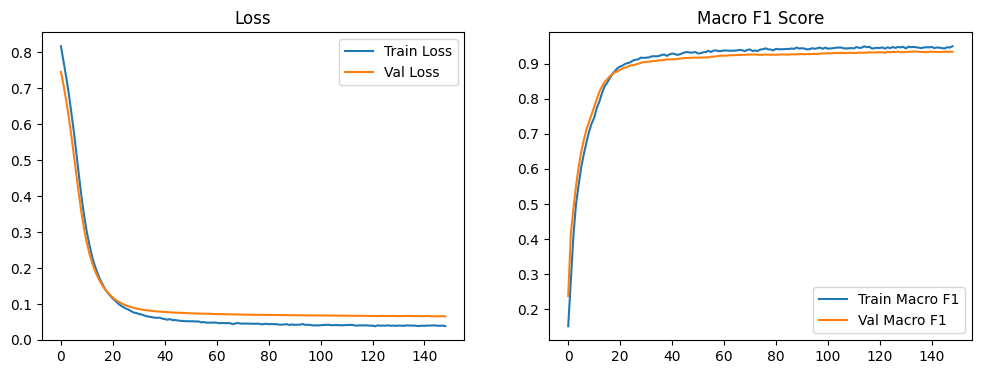

In [593]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_score"], label="Train Macro F1")
plt.plot(history["val_score"], label="Val Macro F1")
plt.legend(); plt.title("Macro F1 Score")
plt.show()

PRC кривая (PRC важнее ROC при дисбалансе).

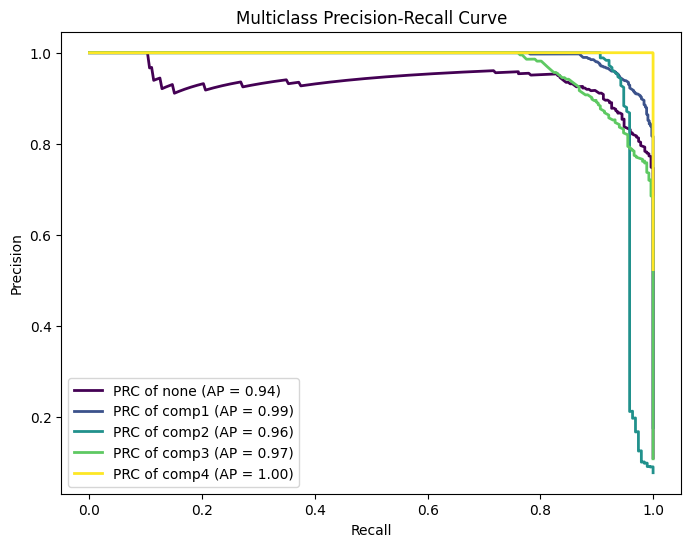

In [594]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Преобразуем y_true в one-hot
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_val_clf_t, classes=np.arange(n_classes))

# Average Precision для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

# Усреднённая PRC
precision["macro"], recall["macro"], _ = precision_recall_curve(
    y_true_bin.ravel(), y_score.ravel()
)
average_precision["macro"] = average_precision_score(y_true_bin, y_score, average="macro")

# График
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PRC of {target_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Feature Importance для нейросетей (LSTM, GRU, DLinear, Transformer).

In [595]:
# from sklearn.inspection import permutation_importance

# def get_permutation_importance_pytorch(model, X_val, y_val, feature_names):
#     model.eval()
#     with torch.no_grad():
#         X_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
#         output = model(X_tensor)
#         if task == "classification":
#             y_pred_proba = torch.softmax(output, dim=1)[:, 1].cpu().numpy() 
#             baseline_score = f1_score(y_val, output.argmax(dim=1).cpu().numpy(), average='macro')
#         else:
#             y_pred_proba = output.cpu().numpy()
#             baseline_score = mean_squared_error(y_val, y_pred_proba)

#     # Перестановка
#     importances = []
#     for i in range(X_val.shape[1]):
#         X_perm = X_val.copy()
#         np.random.shuffle(X_perm[:, i])
#         with torch.no_grad():
#             X_tensor_perm = torch.tensor(X_perm, dtype=torch.float32).to(device)
#             output_perm = model(X_tensor_perm)
#             if task == "classification":
#                 score = f1_score(y_val, output_perm.argmax(dim=1).cpu().numpy(), average='macro')
#             else:
#                 score = mean_squared_error(y_val, output_perm.cpu().numpy())
#         # Для регрессии
#         importance = abs(baseline_score - score)
#         importances.append(importance)

#     return np.array(importances)

# # Применение для LSTM
# perm_importance_lstm = get_permutation_importance_pytorch(
#     lstm_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_lstm.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_lstm[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (LSTM, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [596]:
# GRUModel
gru_model = GRUModel(input_size, hidden_size=129, dropout=0.6).to(device)

# Обучение
y_score, history = Evaluate(gru_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_gru = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 39/39 [00:00<00:00, 374.31it/s]


[Multi] Epoch 1. Train F1: 0.24, Val F1: 0.48


Train 2/200: 100%|██████████| 39/39 [00:00<00:00, 475.96it/s]


[Multi] Epoch 2. Train F1: 0.42, Val F1: 0.69


Train 3/200: 100%|██████████| 39/39 [00:00<00:00, 463.59it/s]


[Multi] Epoch 3. Train F1: 0.58, Val F1: 0.78


Train 4/200: 100%|██████████| 39/39 [00:00<00:00, 488.13it/s]


[Multi] Epoch 4. Train F1: 0.67, Val F1: 0.81


Train 5/200: 100%|██████████| 39/39 [00:00<00:00, 482.83it/s]


[Multi] Epoch 5. Train F1: 0.73, Val F1: 0.83


Train 6/200: 100%|██████████| 39/39 [00:00<00:00, 500.69it/s]


[Multi] Epoch 6. Train F1: 0.77, Val F1: 0.84


Train 7/200: 100%|██████████| 39/39 [00:00<00:00, 499.51it/s]


[Multi] Epoch 7. Train F1: 0.79, Val F1: 0.84


Train 8/200: 100%|██████████| 39/39 [00:00<00:00, 509.88it/s]


[Multi] Epoch 8. Train F1: 0.81, Val F1: 0.85


Train 9/200: 100%|██████████| 39/39 [00:00<00:00, 457.37it/s]


[Multi] Epoch 9. Train F1: 0.83, Val F1: 0.85


Train 10/200: 100%|██████████| 39/39 [00:00<00:00, 413.68it/s]


[Multi] Epoch 10. Train F1: 0.84, Val F1: 0.86


Train 11/200: 100%|██████████| 39/39 [00:00<00:00, 357.39it/s]


[Multi] Epoch 11. Train F1: 0.86, Val F1: 0.87


Train 12/200: 100%|██████████| 39/39 [00:00<00:00, 500.99it/s]


[Multi] Epoch 12. Train F1: 0.86, Val F1: 0.87


Train 13/200: 100%|██████████| 39/39 [00:00<00:00, 446.33it/s]


[Multi] Epoch 13. Train F1: 0.87, Val F1: 0.88


Train 14/200: 100%|██████████| 39/39 [00:00<00:00, 483.66it/s]


[Multi] Epoch 14. Train F1: 0.88, Val F1: 0.88


Train 15/200: 100%|██████████| 39/39 [00:00<00:00, 468.59it/s]


[Multi] Epoch 15. Train F1: 0.88, Val F1: 0.89


Train 16/200: 100%|██████████| 39/39 [00:00<00:00, 440.86it/s]


[Multi] Epoch 16. Train F1: 0.89, Val F1: 0.89


Train 17/200: 100%|██████████| 39/39 [00:00<00:00, 392.18it/s]


[Multi] Epoch 17. Train F1: 0.90, Val F1: 0.89


Train 18/200: 100%|██████████| 39/39 [00:00<00:00, 504.44it/s]


[Multi] Epoch 18. Train F1: 0.90, Val F1: 0.89


Train 19/200: 100%|██████████| 39/39 [00:00<00:00, 442.86it/s]


[Multi] Epoch 19. Train F1: 0.91, Val F1: 0.90


Train 20/200: 100%|██████████| 39/39 [00:00<00:00, 515.48it/s]


[Multi] Epoch 20. Train F1: 0.90, Val F1: 0.90


Train 21/200: 100%|██████████| 39/39 [00:00<00:00, 508.39it/s]


[Multi] Epoch 21. Train F1: 0.91, Val F1: 0.90


Train 22/200: 100%|██████████| 39/39 [00:00<00:00, 526.31it/s]


[Multi] Epoch 22. Train F1: 0.91, Val F1: 0.90


Train 23/200: 100%|██████████| 39/39 [00:00<00:00, 530.77it/s]


[Multi] Epoch 23. Train F1: 0.91, Val F1: 0.90


Train 24/200: 100%|██████████| 39/39 [00:00<00:00, 457.74it/s]


[Multi] Epoch 24. Train F1: 0.91, Val F1: 0.90


Train 25/200: 100%|██████████| 39/39 [00:00<00:00, 523.53it/s]


[Multi] Epoch 25. Train F1: 0.92, Val F1: 0.90


Train 26/200: 100%|██████████| 39/39 [00:00<00:00, 507.64it/s]


[Multi] Epoch 26. Train F1: 0.92, Val F1: 0.90


Train 27/200: 100%|██████████| 39/39 [00:00<00:00, 280.93it/s]


[Multi] Epoch 27. Train F1: 0.92, Val F1: 0.91


Train 28/200: 100%|██████████| 39/39 [00:00<00:00, 431.71it/s]


[Multi] Epoch 28. Train F1: 0.92, Val F1: 0.91


Train 29/200: 100%|██████████| 39/39 [00:00<00:00, 278.60it/s]


[Multi] Epoch 29. Train F1: 0.92, Val F1: 0.91


Train 30/200: 100%|██████████| 39/39 [00:00<00:00, 454.24it/s]


[Multi] Epoch 30. Train F1: 0.92, Val F1: 0.91


Train 31/200: 100%|██████████| 39/39 [00:00<00:00, 427.77it/s]


[Multi] Epoch 31. Train F1: 0.92, Val F1: 0.91


Train 32/200: 100%|██████████| 39/39 [00:00<00:00, 441.46it/s]


[Multi] Epoch 32. Train F1: 0.93, Val F1: 0.91


Train 33/200: 100%|██████████| 39/39 [00:00<00:00, 495.72it/s]


[Multi] Epoch 33. Train F1: 0.92, Val F1: 0.91


Train 34/200: 100%|██████████| 39/39 [00:00<00:00, 510.20it/s]


[Multi] Epoch 34. Train F1: 0.92, Val F1: 0.91


Train 35/200: 100%|██████████| 39/39 [00:00<00:00, 511.35it/s]


[Multi] Epoch 35. Train F1: 0.92, Val F1: 0.91


Train 36/200: 100%|██████████| 39/39 [00:00<00:00, 508.63it/s]


[Multi] Epoch 36. Train F1: 0.93, Val F1: 0.91


Train 37/200: 100%|██████████| 39/39 [00:00<00:00, 467.77it/s]


[Multi] Epoch 37. Train F1: 0.93, Val F1: 0.91


Train 38/200: 100%|██████████| 39/39 [00:00<00:00, 484.25it/s]


[Multi] Epoch 38. Train F1: 0.93, Val F1: 0.91


Train 39/200: 100%|██████████| 39/39 [00:00<00:00, 499.01it/s]


[Multi] Epoch 39. Train F1: 0.93, Val F1: 0.91


Train 40/200: 100%|██████████| 39/39 [00:00<00:00, 478.49it/s]


[Multi] Epoch 40. Train F1: 0.93, Val F1: 0.92


Train 41/200: 100%|██████████| 39/39 [00:00<00:00, 489.73it/s]


[Multi] Epoch 41. Train F1: 0.93, Val F1: 0.92


Train 42/200: 100%|██████████| 39/39 [00:00<00:00, 418.30it/s]


[Multi] Epoch 42. Train F1: 0.93, Val F1: 0.92


Train 43/200: 100%|██████████| 39/39 [00:00<00:00, 503.64it/s]


[Multi] Epoch 43. Train F1: 0.93, Val F1: 0.92


Train 44/200: 100%|██████████| 39/39 [00:00<00:00, 511.26it/s]


[Multi] Epoch 44. Train F1: 0.94, Val F1: 0.92


Train 45/200: 100%|██████████| 39/39 [00:00<00:00, 467.63it/s]


[Multi] Epoch 45. Train F1: 0.93, Val F1: 0.92


Train 46/200: 100%|██████████| 39/39 [00:00<00:00, 511.82it/s]


[Multi] Epoch 46. Train F1: 0.93, Val F1: 0.92


Train 47/200: 100%|██████████| 39/39 [00:00<00:00, 504.35it/s]


[Multi] Epoch 47. Train F1: 0.93, Val F1: 0.92


Train 48/200: 100%|██████████| 39/39 [00:00<00:00, 506.99it/s]


[Multi] Epoch 48. Train F1: 0.94, Val F1: 0.92


Train 49/200: 100%|██████████| 39/39 [00:00<00:00, 511.73it/s]


[Multi] Epoch 49. Train F1: 0.94, Val F1: 0.92


Train 50/200: 100%|██████████| 39/39 [00:00<00:00, 509.43it/s]


[Multi] Epoch 50. Train F1: 0.94, Val F1: 0.92


Train 51/200: 100%|██████████| 39/39 [00:00<00:00, 510.04it/s]


[Multi] Epoch 51. Train F1: 0.94, Val F1: 0.92


Train 52/200: 100%|██████████| 39/39 [00:00<00:00, 513.29it/s]


[Multi] Epoch 52. Train F1: 0.94, Val F1: 0.92


Train 53/200: 100%|██████████| 39/39 [00:00<00:00, 494.86it/s]


[Multi] Epoch 53. Train F1: 0.94, Val F1: 0.92


Train 54/200: 100%|██████████| 39/39 [00:00<00:00, 482.31it/s]


[Multi] Epoch 54. Train F1: 0.94, Val F1: 0.92


Train 55/200: 100%|██████████| 39/39 [00:00<00:00, 475.99it/s]


[Multi] Epoch 55. Train F1: 0.94, Val F1: 0.92


Train 56/200: 100%|██████████| 39/39 [00:00<00:00, 477.55it/s]


[Multi] Epoch 56. Train F1: 0.94, Val F1: 0.92


Train 57/200: 100%|██████████| 39/39 [00:00<00:00, 509.62it/s]


[Multi] Epoch 57. Train F1: 0.94, Val F1: 0.92


Train 58/200: 100%|██████████| 39/39 [00:00<00:00, 502.45it/s]


[Multi] Epoch 58. Train F1: 0.94, Val F1: 0.92


Train 59/200: 100%|██████████| 39/39 [00:00<00:00, 498.86it/s]


[Multi] Epoch 59. Train F1: 0.94, Val F1: 0.93


Train 60/200: 100%|██████████| 39/39 [00:00<00:00, 465.42it/s]


[Multi] Epoch 60. Train F1: 0.94, Val F1: 0.93


Train 61/200: 100%|██████████| 39/39 [00:00<00:00, 508.32it/s]


[Multi] Epoch 61. Train F1: 0.94, Val F1: 0.92


Train 62/200: 100%|██████████| 39/39 [00:00<00:00, 506.59it/s]


[Multi] Epoch 62. Train F1: 0.94, Val F1: 0.92


Train 63/200: 100%|██████████| 39/39 [00:00<00:00, 509.40it/s]


[Multi] Epoch 63. Train F1: 0.94, Val F1: 0.92


Train 64/200: 100%|██████████| 39/39 [00:00<00:00, 478.66it/s]


[Multi] Epoch 64. Train F1: 0.94, Val F1: 0.93


Train 65/200: 100%|██████████| 39/39 [00:00<00:00, 504.64it/s]


[Multi] Epoch 65. Train F1: 0.94, Val F1: 0.93


Train 66/200: 100%|██████████| 39/39 [00:00<00:00, 513.60it/s]


[Multi] Epoch 66. Train F1: 0.94, Val F1: 0.93


Train 67/200: 100%|██████████| 39/39 [00:00<00:00, 505.50it/s]


[Multi] Epoch 67. Train F1: 0.94, Val F1: 0.93


Train 68/200: 100%|██████████| 39/39 [00:00<00:00, 507.22it/s]


[Multi] Epoch 68. Train F1: 0.94, Val F1: 0.93


Train 69/200: 100%|██████████| 39/39 [00:00<00:00, 509.04it/s]


[Multi] Epoch 69. Train F1: 0.94, Val F1: 0.93


Train 70/200: 100%|██████████| 39/39 [00:00<00:00, 503.47it/s]


[Multi] Epoch 70. Train F1: 0.94, Val F1: 0.93


Train 71/200: 100%|██████████| 39/39 [00:00<00:00, 512.81it/s]


[Multi] Epoch 71. Train F1: 0.94, Val F1: 0.93


Train 72/200: 100%|██████████| 39/39 [00:00<00:00, 508.46it/s]


[Multi] Epoch 72. Train F1: 0.94, Val F1: 0.93


Train 73/200: 100%|██████████| 39/39 [00:00<00:00, 432.08it/s]


[Multi] Epoch 73. Train F1: 0.94, Val F1: 0.93


Train 74/200: 100%|██████████| 39/39 [00:00<00:00, 514.21it/s]


[Multi] Epoch 74. Train F1: 0.94, Val F1: 0.93


Train 75/200: 100%|██████████| 39/39 [00:00<00:00, 530.40it/s]


[Multi] Epoch 75. Train F1: 0.95, Val F1: 0.93


Train 76/200: 100%|██████████| 39/39 [00:00<00:00, 544.04it/s]


[Multi] Epoch 76. Train F1: 0.94, Val F1: 0.93


Train 77/200: 100%|██████████| 39/39 [00:00<00:00, 549.38it/s]


[Multi] Epoch 77. Train F1: 0.94, Val F1: 0.93


Train 78/200: 100%|██████████| 39/39 [00:00<00:00, 546.11it/s]


[Multi] Epoch 78. Train F1: 0.94, Val F1: 0.93


Train 79/200: 100%|██████████| 39/39 [00:00<00:00, 517.58it/s]


[Multi] Epoch 79. Train F1: 0.94, Val F1: 0.93


Train 80/200: 100%|██████████| 39/39 [00:00<00:00, 506.13it/s]


[Multi] Epoch 80. Train F1: 0.94, Val F1: 0.93


Train 81/200: 100%|██████████| 39/39 [00:00<00:00, 489.81it/s]


[Multi] Epoch 81. Train F1: 0.95, Val F1: 0.93


Train 82/200: 100%|██████████| 39/39 [00:00<00:00, 470.30it/s]


[Multi] Epoch 82. Train F1: 0.94, Val F1: 0.93


Train 83/200: 100%|██████████| 39/39 [00:00<00:00, 482.87it/s]


[Multi] Epoch 83. Train F1: 0.95, Val F1: 0.93


Train 84/200: 100%|██████████| 39/39 [00:00<00:00, 455.57it/s]


[Multi] Epoch 84. Train F1: 0.94, Val F1: 0.93


Train 85/200: 100%|██████████| 39/39 [00:00<00:00, 450.38it/s]


[Multi] Epoch 85. Train F1: 0.94, Val F1: 0.93


Train 86/200: 100%|██████████| 39/39 [00:00<00:00, 501.23it/s]


[Multi] Epoch 86. Train F1: 0.94, Val F1: 0.93


Train 87/200: 100%|██████████| 39/39 [00:00<00:00, 499.72it/s]


[Multi] Epoch 87. Train F1: 0.95, Val F1: 0.93


Train 88/200: 100%|██████████| 39/39 [00:00<00:00, 506.51it/s]


[Multi] Epoch 88. Train F1: 0.95, Val F1: 0.93


Train 89/200: 100%|██████████| 39/39 [00:00<00:00, 507.03it/s]


[Multi] Epoch 89. Train F1: 0.95, Val F1: 0.93


Train 90/200: 100%|██████████| 39/39 [00:00<00:00, 473.07it/s]


[Multi] Epoch 90. Train F1: 0.95, Val F1: 0.93


Train 91/200: 100%|██████████| 39/39 [00:00<00:00, 462.20it/s]


[Multi] Epoch 91. Train F1: 0.95, Val F1: 0.93


Train 92/200: 100%|██████████| 39/39 [00:00<00:00, 465.11it/s]


[Multi] Epoch 92. Train F1: 0.94, Val F1: 0.93


Train 93/200: 100%|██████████| 39/39 [00:00<00:00, 502.65it/s]


[Multi] Epoch 93. Train F1: 0.94, Val F1: 0.93


Train 94/200: 100%|██████████| 39/39 [00:00<00:00, 479.28it/s]


[Multi] Epoch 94. Train F1: 0.94, Val F1: 0.93


Train 95/200: 100%|██████████| 39/39 [00:00<00:00, 505.61it/s]


[Multi] Epoch 95. Train F1: 0.95, Val F1: 0.93


Train 96/200: 100%|██████████| 39/39 [00:00<00:00, 509.27it/s]


[Multi] Epoch 96. Train F1: 0.95, Val F1: 0.93


Train 97/200: 100%|██████████| 39/39 [00:00<00:00, 511.42it/s]


[Multi] Epoch 97. Train F1: 0.95, Val F1: 0.93


Train 98/200: 100%|██████████| 39/39 [00:00<00:00, 498.31it/s]


[Multi] Epoch 98. Train F1: 0.95, Val F1: 0.93


Train 99/200: 100%|██████████| 39/39 [00:00<00:00, 503.48it/s]


[Multi] Epoch 99. Train F1: 0.95, Val F1: 0.93


Train 100/200: 100%|██████████| 39/39 [00:00<00:00, 507.30it/s]


[Multi] Epoch 100. Train F1: 0.95, Val F1: 0.93


Train 101/200: 100%|██████████| 39/39 [00:00<00:00, 506.19it/s]


[Multi] Epoch 101. Train F1: 0.95, Val F1: 0.93


Train 102/200: 100%|██████████| 39/39 [00:00<00:00, 501.35it/s]


[Multi] Epoch 102. Train F1: 0.95, Val F1: 0.93


Train 103/200: 100%|██████████| 39/39 [00:00<00:00, 394.65it/s]


[Multi] Epoch 103. Train F1: 0.94, Val F1: 0.93


Train 104/200: 100%|██████████| 39/39 [00:00<00:00, 249.45it/s]


[Multi] Epoch 104. Train F1: 0.95, Val F1: 0.93


Train 105/200: 100%|██████████| 39/39 [00:00<00:00, 319.19it/s]


[Multi] Epoch 105. Train F1: 0.95, Val F1: 0.93


Train 106/200: 100%|██████████| 39/39 [00:00<00:00, 460.33it/s]


[Multi] Epoch 106. Train F1: 0.95, Val F1: 0.93


Train 107/200: 100%|██████████| 39/39 [00:00<00:00, 513.62it/s]


[Multi] Epoch 107. Train F1: 0.95, Val F1: 0.93


Train 108/200: 100%|██████████| 39/39 [00:00<00:00, 514.27it/s]


[Multi] Epoch 108. Train F1: 0.95, Val F1: 0.93


Train 109/200: 100%|██████████| 39/39 [00:00<00:00, 489.69it/s]


[Multi] Epoch 109. Train F1: 0.95, Val F1: 0.93


Train 110/200: 100%|██████████| 39/39 [00:00<00:00, 516.88it/s]


[Multi] Epoch 110. Train F1: 0.95, Val F1: 0.93


Train 111/200: 100%|██████████| 39/39 [00:00<00:00, 489.06it/s]


[Multi] Epoch 111. Train F1: 0.95, Val F1: 0.93


Train 112/200: 100%|██████████| 39/39 [00:00<00:00, 503.80it/s]


[Multi] Epoch 112. Train F1: 0.95, Val F1: 0.93


Train 113/200: 100%|██████████| 39/39 [00:00<00:00, 492.57it/s]


[Multi] Epoch 113. Train F1: 0.95, Val F1: 0.93


Train 114/200: 100%|██████████| 39/39 [00:00<00:00, 489.24it/s]


[Multi] Epoch 114. Train F1: 0.95, Val F1: 0.93


Train 115/200: 100%|██████████| 39/39 [00:00<00:00, 496.22it/s]


[Multi] Epoch 115. Train F1: 0.95, Val F1: 0.93


Train 116/200: 100%|██████████| 39/39 [00:00<00:00, 502.36it/s]


[Multi] Epoch 116. Train F1: 0.94, Val F1: 0.93


Train 117/200: 100%|██████████| 39/39 [00:00<00:00, 505.30it/s]


[Multi] Epoch 117. Train F1: 0.95, Val F1: 0.93


Train 118/200: 100%|██████████| 39/39 [00:00<00:00, 454.24it/s]


[Multi] Epoch 118. Train F1: 0.94, Val F1: 0.93


Train 119/200: 100%|██████████| 39/39 [00:00<00:00, 507.91it/s]


[Multi] Epoch 119. Train F1: 0.95, Val F1: 0.93


Train 120/200: 100%|██████████| 39/39 [00:00<00:00, 485.27it/s]


[Multi] Epoch 120. Train F1: 0.95, Val F1: 0.93


Train 121/200: 100%|██████████| 39/39 [00:00<00:00, 493.85it/s]


[Multi] Epoch 121. Train F1: 0.95, Val F1: 0.93


Train 122/200: 100%|██████████| 39/39 [00:04<00:00,  8.83it/s]


[Multi] Epoch 122. Train F1: 0.95, Val F1: 0.93


Train 123/200: 100%|██████████| 39/39 [00:00<00:00, 463.74it/s]


[Multi] Epoch 123. Train F1: 0.95, Val F1: 0.93


Train 124/200: 100%|██████████| 39/39 [00:00<00:00, 464.85it/s]


[Multi] Epoch 124. Train F1: 0.95, Val F1: 0.93


Train 125/200: 100%|██████████| 39/39 [00:00<00:00, 365.34it/s]


[Multi] Epoch 125. Train F1: 0.95, Val F1: 0.93


Train 126/200: 100%|██████████| 39/39 [00:00<00:00, 471.67it/s]


[Multi] Epoch 126. Train F1: 0.95, Val F1: 0.93


Train 127/200: 100%|██████████| 39/39 [00:00<00:00, 329.52it/s]


[Multi] Epoch 127. Train F1: 0.95, Val F1: 0.94


Train 128/200: 100%|██████████| 39/39 [00:00<00:00, 506.20it/s]


[Multi] Epoch 128. Train F1: 0.95, Val F1: 0.93


Train 129/200: 100%|██████████| 39/39 [00:00<00:00, 517.93it/s]


[Multi] Epoch 129. Train F1: 0.95, Val F1: 0.94


Train 130/200: 100%|██████████| 39/39 [00:00<00:00, 500.74it/s]


[Multi] Epoch 130. Train F1: 0.95, Val F1: 0.94


Train 131/200: 100%|██████████| 39/39 [00:00<00:00, 507.54it/s]


[Multi] Epoch 131. Train F1: 0.95, Val F1: 0.94


Train 132/200: 100%|██████████| 39/39 [00:00<00:00, 502.11it/s]


[Multi] Epoch 132. Train F1: 0.95, Val F1: 0.94


Train 133/200: 100%|██████████| 39/39 [00:00<00:00, 486.90it/s]


[Multi] Epoch 133. Train F1: 0.95, Val F1: 0.94


Train 134/200: 100%|██████████| 39/39 [00:00<00:00, 503.77it/s]


[Multi] Epoch 134. Train F1: 0.95, Val F1: 0.94


Train 135/200: 100%|██████████| 39/39 [00:00<00:00, 512.09it/s]


[Multi] Epoch 135. Train F1: 0.95, Val F1: 0.94


Train 136/200: 100%|██████████| 39/39 [00:00<00:00, 516.74it/s]


[Multi] Epoch 136. Train F1: 0.95, Val F1: 0.94


Train 137/200: 100%|██████████| 39/39 [00:00<00:00, 450.71it/s]


[Multi] Epoch 137. Train F1: 0.95, Val F1: 0.94


Train 138/200: 100%|██████████| 39/39 [00:00<00:00, 456.27it/s]


[Multi] Epoch 138. Train F1: 0.95, Val F1: 0.94


Train 139/200: 100%|██████████| 39/39 [00:00<00:00, 432.86it/s]


[Multi] Epoch 139. Train F1: 0.95, Val F1: 0.94


Train 140/200: 100%|██████████| 39/39 [00:00<00:00, 517.96it/s]


[Multi] Epoch 140. Train F1: 0.95, Val F1: 0.94


Train 141/200: 100%|██████████| 39/39 [00:00<00:00, 505.35it/s]


[Multi] Epoch 141. Train F1: 0.95, Val F1: 0.94


Train 142/200: 100%|██████████| 39/39 [00:00<00:00, 504.26it/s]


[Multi] Epoch 142. Train F1: 0.95, Val F1: 0.94


Train 143/200: 100%|██████████| 39/39 [00:00<00:00, 511.76it/s]


[Multi] Epoch 143. Train F1: 0.95, Val F1: 0.94


Train 144/200: 100%|██████████| 39/39 [00:00<00:00, 513.83it/s]


[Multi] Epoch 144. Train F1: 0.95, Val F1: 0.94


Train 145/200: 100%|██████████| 39/39 [00:00<00:00, 508.65it/s]


[Multi] Epoch 145. Train F1: 0.95, Val F1: 0.94


Train 146/200: 100%|██████████| 39/39 [00:00<00:00, 509.54it/s]


[Multi] Epoch 146. Train F1: 0.95, Val F1: 0.94


Train 147/200: 100%|██████████| 39/39 [00:00<00:00, 507.96it/s]


[Multi] Epoch 147. Train F1: 0.95, Val F1: 0.94


Train 148/200: 100%|██████████| 39/39 [00:00<00:00, 513.31it/s]


[Multi] Epoch 148. Train F1: 0.95, Val F1: 0.94


Train 149/200: 100%|██████████| 39/39 [00:00<00:00, 513.85it/s]


[Multi] Epoch 149. Train F1: 0.95, Val F1: 0.94
Early stopping on epoch 149


In [597]:
print("GRU (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_gru, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_gru, average="macro")
print("Macro F1-score:", macro_f1)

GRU (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.93      0.91      0.92       272
       comp1       0.95      0.94      0.95       435
       comp2       0.99      0.91      0.95       192
       comp3       0.87      0.95      0.91       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.97      2450
   macro avg       0.95      0.94      0.94      2450
weighted avg       0.97      0.97      0.97      2450

Macro F1-score: 0.9430440074791624


In [598]:
# # Feature Importance для GRU
# perm_importance_gru = get_permutation_importance_pytorch(
#     gru_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_gru.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_gru[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (GRU, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [599]:
# DLinear с регуляризацией (нейросеть)
dlinear_model = DLinear(
    input_size=input_size,
    n_classes=5,
    dropout=0.3
).to(device)

# Обучение
y_score, history = Evaluate(dlinear_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=300)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_dl = np.argmax(adjusted_scores, axis=1)

Train 1/300: 100%|██████████| 39/39 [00:00<00:00, 857.96it/s]


[Multi] Epoch 1. Train F1: 0.22, Val F1: 0.25


Train 2/300: 100%|██████████| 39/39 [00:00<00:00, 1079.89it/s]


[Multi] Epoch 2. Train F1: 0.25, Val F1: 0.29


Train 3/300: 100%|██████████| 39/39 [00:00<00:00, 1081.95it/s]


[Multi] Epoch 3. Train F1: 0.29, Val F1: 0.33


Train 4/300: 100%|██████████| 39/39 [00:00<00:00, 1115.41it/s]


[Multi] Epoch 4. Train F1: 0.33, Val F1: 0.39


Train 5/300: 100%|██████████| 39/39 [00:00<00:00, 1108.61it/s]


[Multi] Epoch 5. Train F1: 0.37, Val F1: 0.45


Train 6/300: 100%|██████████| 39/39 [00:00<00:00, 1121.85it/s]


[Multi] Epoch 6. Train F1: 0.43, Val F1: 0.52


Train 7/300: 100%|██████████| 39/39 [00:00<00:00, 1103.44it/s]


[Multi] Epoch 7. Train F1: 0.48, Val F1: 0.58


Train 8/300: 100%|██████████| 39/39 [00:00<00:00, 1108.65it/s]


[Multi] Epoch 8. Train F1: 0.53, Val F1: 0.63


Train 9/300: 100%|██████████| 39/39 [00:00<00:00, 1120.69it/s]


[Multi] Epoch 9. Train F1: 0.58, Val F1: 0.68


Train 10/300: 100%|██████████| 39/39 [00:00<00:00, 1014.86it/s]


[Multi] Epoch 10. Train F1: 0.61, Val F1: 0.71


Train 11/300: 100%|██████████| 39/39 [00:00<00:00, 1102.35it/s]


[Multi] Epoch 11. Train F1: 0.66, Val F1: 0.75


Train 12/300: 100%|██████████| 39/39 [00:00<00:00, 960.92it/s]


[Multi] Epoch 12. Train F1: 0.67, Val F1: 0.77


Train 13/300: 100%|██████████| 39/39 [00:00<00:00, 1066.07it/s]


[Multi] Epoch 13. Train F1: 0.70, Val F1: 0.78


Train 14/300: 100%|██████████| 39/39 [00:00<00:00, 1129.56it/s]


[Multi] Epoch 14. Train F1: 0.72, Val F1: 0.79


Train 15/300: 100%|██████████| 39/39 [00:00<00:00, 1101.16it/s]


[Multi] Epoch 15. Train F1: 0.74, Val F1: 0.80


Train 16/300: 100%|██████████| 39/39 [00:00<00:00, 1123.12it/s]


[Multi] Epoch 16. Train F1: 0.75, Val F1: 0.81


Train 17/300: 100%|██████████| 39/39 [00:00<00:00, 1111.74it/s]


[Multi] Epoch 17. Train F1: 0.76, Val F1: 0.82


Train 18/300: 100%|██████████| 39/39 [00:00<00:00, 1128.24it/s]


[Multi] Epoch 18. Train F1: 0.77, Val F1: 0.83


Train 19/300: 100%|██████████| 39/39 [00:00<00:00, 1119.60it/s]


[Multi] Epoch 19. Train F1: 0.77, Val F1: 0.83


Train 20/300: 100%|██████████| 39/39 [00:00<00:00, 1048.19it/s]


[Multi] Epoch 20. Train F1: 0.78, Val F1: 0.84


Train 21/300: 100%|██████████| 39/39 [00:00<00:00, 1126.87it/s]


[Multi] Epoch 21. Train F1: 0.79, Val F1: 0.84


Train 22/300: 100%|██████████| 39/39 [00:00<00:00, 1118.60it/s]


[Multi] Epoch 22. Train F1: 0.80, Val F1: 0.85


Train 23/300: 100%|██████████| 39/39 [00:00<00:00, 1124.83it/s]


[Multi] Epoch 23. Train F1: 0.81, Val F1: 0.85


Train 24/300: 100%|██████████| 39/39 [00:00<00:00, 1110.70it/s]


[Multi] Epoch 24. Train F1: 0.81, Val F1: 0.85


Train 25/300: 100%|██████████| 39/39 [00:00<00:00, 1121.13it/s]


[Multi] Epoch 25. Train F1: 0.81, Val F1: 0.86


Train 26/300: 100%|██████████| 39/39 [00:00<00:00, 1119.85it/s]


[Multi] Epoch 26. Train F1: 0.81, Val F1: 0.86


Train 27/300: 100%|██████████| 39/39 [00:00<00:00, 1109.57it/s]


[Multi] Epoch 27. Train F1: 0.82, Val F1: 0.86


Train 28/300: 100%|██████████| 39/39 [00:00<00:00, 1120.69it/s]


[Multi] Epoch 28. Train F1: 0.82, Val F1: 0.86


Train 29/300: 100%|██████████| 39/39 [00:00<00:00, 1106.73it/s]


[Multi] Epoch 29. Train F1: 0.82, Val F1: 0.87


Train 30/300: 100%|██████████| 39/39 [00:00<00:00, 1062.04it/s]


[Multi] Epoch 30. Train F1: 0.82, Val F1: 0.87


Train 31/300: 100%|██████████| 39/39 [00:00<00:00, 993.28it/s]


[Multi] Epoch 31. Train F1: 0.83, Val F1: 0.87


Train 32/300: 100%|██████████| 39/39 [00:00<00:00, 1070.02it/s]


[Multi] Epoch 32. Train F1: 0.83, Val F1: 0.87


Train 33/300: 100%|██████████| 39/39 [00:00<00:00, 1112.47it/s]


[Multi] Epoch 33. Train F1: 0.83, Val F1: 0.87


Train 34/300: 100%|██████████| 39/39 [00:00<00:00, 1096.49it/s]


[Multi] Epoch 34. Train F1: 0.83, Val F1: 0.88


Train 35/300: 100%|██████████| 39/39 [00:00<00:00, 1123.30it/s]


[Multi] Epoch 35. Train F1: 0.84, Val F1: 0.88


Train 36/300: 100%|██████████| 39/39 [00:00<00:00, 1109.75it/s]


[Multi] Epoch 36. Train F1: 0.84, Val F1: 0.88


Train 37/300: 100%|██████████| 39/39 [00:00<00:00, 1109.28it/s]


[Multi] Epoch 37. Train F1: 0.84, Val F1: 0.88


Train 38/300: 100%|██████████| 39/39 [00:00<00:00, 1099.55it/s]


[Multi] Epoch 38. Train F1: 0.84, Val F1: 0.88


Train 39/300: 100%|██████████| 39/39 [00:00<00:00, 1086.22it/s]


[Multi] Epoch 39. Train F1: 0.84, Val F1: 0.88


Train 40/300: 100%|██████████| 39/39 [00:00<00:00, 1116.80it/s]


[Multi] Epoch 40. Train F1: 0.84, Val F1: 0.88


Train 41/300: 100%|██████████| 39/39 [00:00<00:00, 1052.23it/s]


[Multi] Epoch 41. Train F1: 0.84, Val F1: 0.88


Train 42/300: 100%|██████████| 39/39 [00:00<00:00, 1120.60it/s]


[Multi] Epoch 42. Train F1: 0.85, Val F1: 0.88


Train 43/300: 100%|██████████| 39/39 [00:00<00:00, 1066.31it/s]


[Multi] Epoch 43. Train F1: 0.85, Val F1: 0.88


Train 44/300: 100%|██████████| 39/39 [00:00<00:00, 1124.15it/s]


[Multi] Epoch 44. Train F1: 0.85, Val F1: 0.88


Train 45/300: 100%|██████████| 39/39 [00:00<00:00, 1126.07it/s]


[Multi] Epoch 45. Train F1: 0.84, Val F1: 0.88


Train 46/300: 100%|██████████| 39/39 [00:00<00:00, 1120.73it/s]


[Multi] Epoch 46. Train F1: 0.85, Val F1: 0.88


Train 47/300: 100%|██████████| 39/39 [00:00<00:00, 1125.48it/s]


[Multi] Epoch 47. Train F1: 0.85, Val F1: 0.88


Train 48/300: 100%|██████████| 39/39 [00:00<00:00, 1124.99it/s]


[Multi] Epoch 48. Train F1: 0.85, Val F1: 0.89


Train 49/300: 100%|██████████| 39/39 [00:00<00:00, 1095.91it/s]


[Multi] Epoch 49. Train F1: 0.85, Val F1: 0.89


Train 50/300: 100%|██████████| 39/39 [00:00<00:00, 983.95it/s]


[Multi] Epoch 50. Train F1: 0.85, Val F1: 0.89


Train 51/300: 100%|██████████| 39/39 [00:00<00:00, 1093.05it/s]


[Multi] Epoch 51. Train F1: 0.85, Val F1: 0.89


Train 52/300: 100%|██████████| 39/39 [00:00<00:00, 1126.78it/s]


[Multi] Epoch 52. Train F1: 0.86, Val F1: 0.89


Train 53/300: 100%|██████████| 39/39 [00:00<00:00, 1109.38it/s]


[Multi] Epoch 53. Train F1: 0.85, Val F1: 0.89


Train 54/300: 100%|██████████| 39/39 [00:00<00:00, 1118.92it/s]


[Multi] Epoch 54. Train F1: 0.85, Val F1: 0.89


Train 55/300: 100%|██████████| 39/39 [00:00<00:00, 1122.17it/s]


[Multi] Epoch 55. Train F1: 0.85, Val F1: 0.89


Train 56/300: 100%|██████████| 39/39 [00:00<00:00, 1109.28it/s]


[Multi] Epoch 56. Train F1: 0.85, Val F1: 0.89


Train 57/300: 100%|██████████| 39/39 [00:00<00:00, 1135.90it/s]


[Multi] Epoch 57. Train F1: 0.86, Val F1: 0.89


Train 58/300: 100%|██████████| 39/39 [00:00<00:00, 1094.13it/s]


[Multi] Epoch 58. Train F1: 0.86, Val F1: 0.89


Train 59/300: 100%|██████████| 39/39 [00:00<00:00, 1114.54it/s]


[Multi] Epoch 59. Train F1: 0.85, Val F1: 0.89


Train 60/300: 100%|██████████| 39/39 [00:00<00:00, 1097.94it/s]


[Multi] Epoch 60. Train F1: 0.87, Val F1: 0.89


Train 61/300: 100%|██████████| 39/39 [00:00<00:00, 580.15it/s]


[Multi] Epoch 61. Train F1: 0.85, Val F1: 0.89


Train 62/300: 100%|██████████| 39/39 [00:00<00:00, 1094.31it/s]


[Multi] Epoch 62. Train F1: 0.85, Val F1: 0.89


Train 63/300: 100%|██████████| 39/39 [00:00<00:00, 1098.96it/s]


[Multi] Epoch 63. Train F1: 0.86, Val F1: 0.89


Train 64/300: 100%|██████████| 39/39 [00:00<00:00, 1040.28it/s]


[Multi] Epoch 64. Train F1: 0.86, Val F1: 0.89


Train 65/300: 100%|██████████| 39/39 [00:00<00:00, 1066.06it/s]


[Multi] Epoch 65. Train F1: 0.86, Val F1: 0.89


Train 66/300: 100%|██████████| 39/39 [00:00<00:00, 1010.15it/s]


[Multi] Epoch 66. Train F1: 0.86, Val F1: 0.89


Train 67/300: 100%|██████████| 39/39 [00:00<00:00, 969.41it/s]


[Multi] Epoch 67. Train F1: 0.86, Val F1: 0.89


Train 68/300: 100%|██████████| 39/39 [00:00<00:00, 1119.76it/s]


[Multi] Epoch 68. Train F1: 0.86, Val F1: 0.89


Train 69/300: 100%|██████████| 39/39 [00:00<00:00, 1113.05it/s]


[Multi] Epoch 69. Train F1: 0.86, Val F1: 0.89


Train 70/300: 100%|██████████| 39/39 [00:00<00:00, 1105.29it/s]


[Multi] Epoch 70. Train F1: 0.87, Val F1: 0.89


Train 71/300: 100%|██████████| 39/39 [00:00<00:00, 1102.48it/s]


[Multi] Epoch 71. Train F1: 0.86, Val F1: 0.89


Train 72/300: 100%|██████████| 39/39 [00:00<00:00, 1125.77it/s]


[Multi] Epoch 72. Train F1: 0.86, Val F1: 0.90


Train 73/300: 100%|██████████| 39/39 [00:00<00:00, 1054.39it/s]


[Multi] Epoch 73. Train F1: 0.86, Val F1: 0.90


Train 74/300: 100%|██████████| 39/39 [00:00<00:00, 1020.09it/s]


[Multi] Epoch 74. Train F1: 0.87, Val F1: 0.90


Train 75/300: 100%|██████████| 39/39 [00:00<00:00, 1107.55it/s]


[Multi] Epoch 75. Train F1: 0.86, Val F1: 0.90


Train 76/300: 100%|██████████| 39/39 [00:00<00:00, 1018.75it/s]


[Multi] Epoch 76. Train F1: 0.87, Val F1: 0.90


Train 77/300: 100%|██████████| 39/39 [00:00<00:00, 1062.39it/s]


[Multi] Epoch 77. Train F1: 0.87, Val F1: 0.90


Train 78/300: 100%|██████████| 39/39 [00:00<00:00, 1090.18it/s]


[Multi] Epoch 78. Train F1: 0.86, Val F1: 0.90


Train 79/300: 100%|██████████| 39/39 [00:00<00:00, 1090.21it/s]


[Multi] Epoch 79. Train F1: 0.87, Val F1: 0.90


Train 80/300: 100%|██████████| 39/39 [00:00<00:00, 1069.99it/s]


[Multi] Epoch 80. Train F1: 0.86, Val F1: 0.90


Train 81/300: 100%|██████████| 39/39 [00:00<00:00, 1078.66it/s]


[Multi] Epoch 81. Train F1: 0.86, Val F1: 0.90


Train 82/300: 100%|██████████| 39/39 [00:00<00:00, 1072.23it/s]


[Multi] Epoch 82. Train F1: 0.86, Val F1: 0.90


Train 83/300: 100%|██████████| 39/39 [00:00<00:00, 1073.88it/s]


[Multi] Epoch 83. Train F1: 0.87, Val F1: 0.90


Train 84/300: 100%|██████████| 39/39 [00:00<00:00, 1120.75it/s]


[Multi] Epoch 84. Train F1: 0.87, Val F1: 0.90


Train 85/300: 100%|██████████| 39/39 [00:00<00:00, 1001.20it/s]


[Multi] Epoch 85. Train F1: 0.87, Val F1: 0.90


Train 86/300: 100%|██████████| 39/39 [00:00<00:00, 1088.23it/s]


[Multi] Epoch 86. Train F1: 0.87, Val F1: 0.90


Train 87/300: 100%|██████████| 39/39 [00:00<00:00, 1082.49it/s]


[Multi] Epoch 87. Train F1: 0.87, Val F1: 0.90


Train 88/300: 100%|██████████| 39/39 [00:00<00:00, 1108.58it/s]


[Multi] Epoch 88. Train F1: 0.87, Val F1: 0.90


Train 89/300: 100%|██████████| 39/39 [00:00<00:00, 1041.37it/s]


[Multi] Epoch 89. Train F1: 0.87, Val F1: 0.90


Train 90/300: 100%|██████████| 39/39 [00:00<00:00, 1088.32it/s]


[Multi] Epoch 90. Train F1: 0.87, Val F1: 0.90


Train 91/300: 100%|██████████| 39/39 [00:00<00:00, 1022.39it/s]


[Multi] Epoch 91. Train F1: 0.86, Val F1: 0.90


Train 92/300: 100%|██████████| 39/39 [00:00<00:00, 1040.00it/s]


[Multi] Epoch 92. Train F1: 0.86, Val F1: 0.90


Train 93/300: 100%|██████████| 39/39 [00:00<00:00, 1056.68it/s]


[Multi] Epoch 93. Train F1: 0.87, Val F1: 0.90


Train 94/300: 100%|██████████| 39/39 [00:00<00:00, 961.16it/s]


[Multi] Epoch 94. Train F1: 0.87, Val F1: 0.90


Train 95/300: 100%|██████████| 39/39 [00:00<00:00, 965.87it/s]


[Multi] Epoch 95. Train F1: 0.87, Val F1: 0.90


Train 96/300: 100%|██████████| 39/39 [00:00<00:00, 1042.11it/s]


[Multi] Epoch 96. Train F1: 0.87, Val F1: 0.90


Train 97/300: 100%|██████████| 39/39 [00:00<00:00, 1022.71it/s]


[Multi] Epoch 97. Train F1: 0.87, Val F1: 0.90


Train 98/300: 100%|██████████| 39/39 [00:00<00:00, 1035.39it/s]


[Multi] Epoch 98. Train F1: 0.87, Val F1: 0.91


Train 99/300: 100%|██████████| 39/39 [00:00<00:00, 1032.84it/s]


[Multi] Epoch 99. Train F1: 0.87, Val F1: 0.91


Train 100/300: 100%|██████████| 39/39 [00:00<00:00, 1079.79it/s]


[Multi] Epoch 100. Train F1: 0.87, Val F1: 0.91


Train 101/300: 100%|██████████| 39/39 [00:00<00:00, 1054.40it/s]


[Multi] Epoch 101. Train F1: 0.88, Val F1: 0.91


Train 102/300: 100%|██████████| 39/39 [00:00<00:00, 661.52it/s]


[Multi] Epoch 102. Train F1: 0.87, Val F1: 0.91


Train 103/300: 100%|██████████| 39/39 [00:00<00:00, 1010.93it/s]


[Multi] Epoch 103. Train F1: 0.87, Val F1: 0.91


Train 104/300: 100%|██████████| 39/39 [00:00<00:00, 1073.11it/s]


[Multi] Epoch 104. Train F1: 0.88, Val F1: 0.91


Train 105/300: 100%|██████████| 39/39 [00:00<00:00, 964.32it/s]


[Multi] Epoch 105. Train F1: 0.87, Val F1: 0.91


Train 106/300: 100%|██████████| 39/39 [00:00<00:00, 1046.64it/s]


[Multi] Epoch 106. Train F1: 0.87, Val F1: 0.91


Train 107/300: 100%|██████████| 39/39 [00:00<00:00, 1074.69it/s]


[Multi] Epoch 107. Train F1: 0.87, Val F1: 0.91


Train 108/300: 100%|██████████| 39/39 [00:00<00:00, 1022.92it/s]


[Multi] Epoch 108. Train F1: 0.87, Val F1: 0.91


Train 109/300: 100%|██████████| 39/39 [00:00<00:00, 1066.39it/s]


[Multi] Epoch 109. Train F1: 0.87, Val F1: 0.91


Train 110/300: 100%|██████████| 39/39 [00:00<00:00, 1012.31it/s]


[Multi] Epoch 110. Train F1: 0.87, Val F1: 0.91


Train 111/300: 100%|██████████| 39/39 [00:00<00:00, 1092.56it/s]


[Multi] Epoch 111. Train F1: 0.88, Val F1: 0.91


Train 112/300: 100%|██████████| 39/39 [00:00<00:00, 1070.47it/s]


[Multi] Epoch 112. Train F1: 0.88, Val F1: 0.91


Train 113/300: 100%|██████████| 39/39 [00:00<00:00, 1073.23it/s]


[Multi] Epoch 113. Train F1: 0.87, Val F1: 0.91


Train 114/300: 100%|██████████| 39/39 [00:00<00:00, 1071.60it/s]


[Multi] Epoch 114. Train F1: 0.88, Val F1: 0.91


Train 115/300: 100%|██████████| 39/39 [00:00<00:00, 1034.20it/s]


[Multi] Epoch 115. Train F1: 0.88, Val F1: 0.91


Train 116/300: 100%|██████████| 39/39 [00:00<00:00, 1048.48it/s]


[Multi] Epoch 116. Train F1: 0.88, Val F1: 0.91


Train 117/300: 100%|██████████| 39/39 [00:00<00:00, 1044.71it/s]


[Multi] Epoch 117. Train F1: 0.87, Val F1: 0.91


Train 118/300: 100%|██████████| 39/39 [00:00<00:00, 1071.93it/s]


[Multi] Epoch 118. Train F1: 0.88, Val F1: 0.91


Train 119/300: 100%|██████████| 39/39 [00:00<00:00, 1048.90it/s]


[Multi] Epoch 119. Train F1: 0.87, Val F1: 0.91


Train 120/300: 100%|██████████| 39/39 [00:00<00:00, 1126.00it/s]


[Multi] Epoch 120. Train F1: 0.88, Val F1: 0.91


Train 121/300: 100%|██████████| 39/39 [00:00<00:00, 1050.54it/s]


[Multi] Epoch 121. Train F1: 0.87, Val F1: 0.91


Train 122/300: 100%|██████████| 39/39 [00:00<00:00, 939.44it/s]


[Multi] Epoch 122. Train F1: 0.87, Val F1: 0.91


Train 123/300: 100%|██████████| 39/39 [00:00<00:00, 1102.81it/s]


[Multi] Epoch 123. Train F1: 0.87, Val F1: 0.91


Train 124/300: 100%|██████████| 39/39 [00:00<00:00, 1112.41it/s]


[Multi] Epoch 124. Train F1: 0.88, Val F1: 0.91


Train 125/300: 100%|██████████| 39/39 [00:00<00:00, 1105.88it/s]


[Multi] Epoch 125. Train F1: 0.88, Val F1: 0.91


Train 126/300: 100%|██████████| 39/39 [00:00<00:00, 1112.35it/s]


[Multi] Epoch 126. Train F1: 0.88, Val F1: 0.91


Train 127/300: 100%|██████████| 39/39 [00:00<00:00, 978.70it/s]


[Multi] Epoch 127. Train F1: 0.88, Val F1: 0.91


Train 128/300: 100%|██████████| 39/39 [00:00<00:00, 998.36it/s]


[Multi] Epoch 128. Train F1: 0.88, Val F1: 0.91


Train 129/300: 100%|██████████| 39/39 [00:00<00:00, 1062.70it/s]


[Multi] Epoch 129. Train F1: 0.88, Val F1: 0.91


Train 130/300: 100%|██████████| 39/39 [00:00<00:00, 1116.94it/s]


[Multi] Epoch 130. Train F1: 0.87, Val F1: 0.91


Train 131/300: 100%|██████████| 39/39 [00:00<00:00, 1093.52it/s]


[Multi] Epoch 131. Train F1: 0.88, Val F1: 0.91


Train 132/300: 100%|██████████| 39/39 [00:00<00:00, 1122.53it/s]


[Multi] Epoch 132. Train F1: 0.88, Val F1: 0.91


Train 133/300: 100%|██████████| 39/39 [00:00<00:00, 1067.14it/s]


[Multi] Epoch 133. Train F1: 0.88, Val F1: 0.91


Train 134/300: 100%|██████████| 39/39 [00:00<00:00, 1068.46it/s]


[Multi] Epoch 134. Train F1: 0.87, Val F1: 0.91


Train 135/300: 100%|██████████| 39/39 [00:00<00:00, 451.58it/s]


[Multi] Epoch 135. Train F1: 0.87, Val F1: 0.91


Train 136/300: 100%|██████████| 39/39 [00:00<00:00, 1098.04it/s]


[Multi] Epoch 136. Train F1: 0.88, Val F1: 0.91


Train 137/300: 100%|██████████| 39/39 [00:00<00:00, 1128.12it/s]


[Multi] Epoch 137. Train F1: 0.88, Val F1: 0.91


Train 138/300: 100%|██████████| 39/39 [00:00<00:00, 1126.58it/s]


[Multi] Epoch 138. Train F1: 0.88, Val F1: 0.91


Train 139/300: 100%|██████████| 39/39 [00:00<00:00, 1098.13it/s]


[Multi] Epoch 139. Train F1: 0.88, Val F1: 0.92


Train 140/300: 100%|██████████| 39/39 [00:00<00:00, 1080.63it/s]


[Multi] Epoch 140. Train F1: 0.88, Val F1: 0.92


Train 141/300: 100%|██████████| 39/39 [00:00<00:00, 1084.99it/s]


[Multi] Epoch 141. Train F1: 0.88, Val F1: 0.92


Train 142/300: 100%|██████████| 39/39 [00:00<00:00, 1070.35it/s]


[Multi] Epoch 142. Train F1: 0.88, Val F1: 0.92


Train 143/300: 100%|██████████| 39/39 [00:00<00:00, 1073.29it/s]


[Multi] Epoch 143. Train F1: 0.88, Val F1: 0.92


Train 144/300: 100%|██████████| 39/39 [00:00<00:00, 1037.98it/s]


[Multi] Epoch 144. Train F1: 0.88, Val F1: 0.92


Train 145/300: 100%|██████████| 39/39 [00:00<00:00, 1059.81it/s]


[Multi] Epoch 145. Train F1: 0.88, Val F1: 0.92


Train 146/300: 100%|██████████| 39/39 [00:00<00:00, 1021.02it/s]


[Multi] Epoch 146. Train F1: 0.88, Val F1: 0.92


Train 147/300: 100%|██████████| 39/39 [00:00<00:00, 887.90it/s]


[Multi] Epoch 147. Train F1: 0.88, Val F1: 0.92


Train 148/300: 100%|██████████| 39/39 [00:00<00:00, 1097.15it/s]


[Multi] Epoch 148. Train F1: 0.88, Val F1: 0.92


Train 149/300: 100%|██████████| 39/39 [00:00<00:00, 1121.98it/s]


[Multi] Epoch 149. Train F1: 0.88, Val F1: 0.92


Train 150/300: 100%|██████████| 39/39 [00:00<00:00, 1089.20it/s]


[Multi] Epoch 150. Train F1: 0.89, Val F1: 0.92


Train 151/300: 100%|██████████| 39/39 [00:00<00:00, 1110.58it/s]


[Multi] Epoch 151. Train F1: 0.89, Val F1: 0.92


Train 152/300: 100%|██████████| 39/39 [00:00<00:00, 1123.03it/s]


[Multi] Epoch 152. Train F1: 0.88, Val F1: 0.92


Train 153/300: 100%|██████████| 39/39 [00:00<00:00, 1123.17it/s]


[Multi] Epoch 153. Train F1: 0.88, Val F1: 0.92


Train 154/300: 100%|██████████| 39/39 [00:00<00:00, 524.39it/s]


[Multi] Epoch 154. Train F1: 0.88, Val F1: 0.92


Train 155/300: 100%|██████████| 39/39 [00:00<00:00, 1076.96it/s]


[Multi] Epoch 155. Train F1: 0.88, Val F1: 0.92


Train 156/300: 100%|██████████| 39/39 [00:00<00:00, 1098.83it/s]


[Multi] Epoch 156. Train F1: 0.88, Val F1: 0.92


Train 157/300: 100%|██████████| 39/39 [00:00<00:00, 1133.23it/s]


[Multi] Epoch 157. Train F1: 0.88, Val F1: 0.92


Train 158/300: 100%|██████████| 39/39 [00:00<00:00, 1109.66it/s]


[Multi] Epoch 158. Train F1: 0.88, Val F1: 0.92


Train 159/300: 100%|██████████| 39/39 [00:00<00:00, 1120.27it/s]


[Multi] Epoch 159. Train F1: 0.88, Val F1: 0.92


Train 160/300: 100%|██████████| 39/39 [00:00<00:00, 1116.13it/s]


[Multi] Epoch 160. Train F1: 0.88, Val F1: 0.92


Train 161/300: 100%|██████████| 39/39 [00:00<00:00, 1104.91it/s]


[Multi] Epoch 161. Train F1: 0.88, Val F1: 0.92


Train 162/300: 100%|██████████| 39/39 [00:00<00:00, 1117.45it/s]


[Multi] Epoch 162. Train F1: 0.88, Val F1: 0.92


Train 163/300: 100%|██████████| 39/39 [00:00<00:00, 1096.06it/s]


[Multi] Epoch 163. Train F1: 0.88, Val F1: 0.92


Train 164/300: 100%|██████████| 39/39 [00:00<00:00, 1120.50it/s]


[Multi] Epoch 164. Train F1: 0.88, Val F1: 0.92


Train 165/300: 100%|██████████| 39/39 [00:00<00:00, 1106.54it/s]


[Multi] Epoch 165. Train F1: 0.89, Val F1: 0.92


Train 166/300: 100%|██████████| 39/39 [00:00<00:00, 1049.74it/s]


[Multi] Epoch 166. Train F1: 0.88, Val F1: 0.92


Train 167/300: 100%|██████████| 39/39 [00:00<00:00, 1082.76it/s]


[Multi] Epoch 167. Train F1: 0.89, Val F1: 0.92


Train 168/300: 100%|██████████| 39/39 [00:00<00:00, 1112.60it/s]


[Multi] Epoch 168. Train F1: 0.88, Val F1: 0.92


Train 169/300: 100%|██████████| 39/39 [00:00<00:00, 1124.66it/s]


[Multi] Epoch 169. Train F1: 0.88, Val F1: 0.92


Train 170/300: 100%|██████████| 39/39 [00:00<00:00, 1103.37it/s]


[Multi] Epoch 170. Train F1: 0.88, Val F1: 0.92


Train 171/300: 100%|██████████| 39/39 [00:00<00:00, 1137.55it/s]


[Multi] Epoch 171. Train F1: 0.89, Val F1: 0.92


Train 172/300: 100%|██████████| 39/39 [00:00<00:00, 1082.37it/s]


[Multi] Epoch 172. Train F1: 0.89, Val F1: 0.92


Train 173/300: 100%|██████████| 39/39 [00:00<00:00, 1100.83it/s]


[Multi] Epoch 173. Train F1: 0.88, Val F1: 0.92


Train 174/300: 100%|██████████| 39/39 [00:00<00:00, 1108.75it/s]


[Multi] Epoch 174. Train F1: 0.89, Val F1: 0.92


Train 175/300: 100%|██████████| 39/39 [00:00<00:00, 1080.27it/s]


[Multi] Epoch 175. Train F1: 0.89, Val F1: 0.92


Train 176/300: 100%|██████████| 39/39 [00:00<00:00, 1115.53it/s]


[Multi] Epoch 176. Train F1: 0.88, Val F1: 0.92


Train 177/300: 100%|██████████| 39/39 [00:00<00:00, 1094.83it/s]


[Multi] Epoch 177. Train F1: 0.88, Val F1: 0.92


Train 178/300: 100%|██████████| 39/39 [00:00<00:00, 1085.27it/s]


[Multi] Epoch 178. Train F1: 0.89, Val F1: 0.92


Train 179/300: 100%|██████████| 39/39 [00:00<00:00, 1081.30it/s]


[Multi] Epoch 179. Train F1: 0.89, Val F1: 0.92


Train 180/300: 100%|██████████| 39/39 [00:00<00:00, 1095.30it/s]


[Multi] Epoch 180. Train F1: 0.88, Val F1: 0.92


Train 181/300: 100%|██████████| 39/39 [00:00<00:00, 1120.88it/s]


[Multi] Epoch 181. Train F1: 0.88, Val F1: 0.92


Train 182/300: 100%|██████████| 39/39 [00:00<00:00, 1111.65it/s]


[Multi] Epoch 182. Train F1: 0.88, Val F1: 0.92


Train 183/300: 100%|██████████| 39/39 [00:00<00:00, 1118.79it/s]


[Multi] Epoch 183. Train F1: 0.88, Val F1: 0.92


Train 184/300: 100%|██████████| 39/39 [00:00<00:00, 1097.17it/s]


[Multi] Epoch 184. Train F1: 0.89, Val F1: 0.92


Train 185/300: 100%|██████████| 39/39 [00:03<00:00, 11.01it/s]


[Multi] Epoch 185. Train F1: 0.89, Val F1: 0.92


Train 186/300: 100%|██████████| 39/39 [00:00<00:00, 788.36it/s]


[Multi] Epoch 186. Train F1: 0.89, Val F1: 0.92


Train 187/300: 100%|██████████| 39/39 [00:00<00:00, 825.36it/s]


[Multi] Epoch 187. Train F1: 0.88, Val F1: 0.92


Train 188/300: 100%|██████████| 39/39 [00:00<00:00, 736.90it/s]


[Multi] Epoch 188. Train F1: 0.89, Val F1: 0.93


Train 189/300: 100%|██████████| 39/39 [00:00<00:00, 808.68it/s]


[Multi] Epoch 189. Train F1: 0.88, Val F1: 0.93


Train 190/300: 100%|██████████| 39/39 [00:00<00:00, 1113.40it/s]


[Multi] Epoch 190. Train F1: 0.89, Val F1: 0.93


Train 191/300: 100%|██████████| 39/39 [00:00<00:00, 1043.48it/s]


[Multi] Epoch 191. Train F1: 0.88, Val F1: 0.93


Train 192/300: 100%|██████████| 39/39 [00:00<00:00, 1110.76it/s]


[Multi] Epoch 192. Train F1: 0.89, Val F1: 0.93


Train 193/300: 100%|██████████| 39/39 [00:00<00:00, 1038.54it/s]


[Multi] Epoch 193. Train F1: 0.89, Val F1: 0.93


Train 194/300: 100%|██████████| 39/39 [00:00<00:00, 1056.08it/s]


[Multi] Epoch 194. Train F1: 0.88, Val F1: 0.93


Train 195/300: 100%|██████████| 39/39 [00:00<00:00, 1100.33it/s]


[Multi] Epoch 195. Train F1: 0.88, Val F1: 0.93


Train 196/300: 100%|██████████| 39/39 [00:00<00:00, 870.05it/s]


[Multi] Epoch 196. Train F1: 0.89, Val F1: 0.93


Train 197/300: 100%|██████████| 39/39 [00:00<00:00, 1002.99it/s]


[Multi] Epoch 197. Train F1: 0.89, Val F1: 0.93


Train 198/300: 100%|██████████| 39/39 [00:00<00:00, 1038.64it/s]


[Multi] Epoch 198. Train F1: 0.88, Val F1: 0.93


Train 199/300: 100%|██████████| 39/39 [00:00<00:00, 1048.30it/s]


[Multi] Epoch 199. Train F1: 0.89, Val F1: 0.93


Train 200/300: 100%|██████████| 39/39 [00:00<00:00, 1010.60it/s]


[Multi] Epoch 200. Train F1: 0.89, Val F1: 0.93


Train 201/300: 100%|██████████| 39/39 [00:00<00:00, 959.34it/s]


[Multi] Epoch 201. Train F1: 0.89, Val F1: 0.93


Train 202/300: 100%|██████████| 39/39 [00:00<00:00, 1068.11it/s]


[Multi] Epoch 202. Train F1: 0.89, Val F1: 0.93


Train 203/300: 100%|██████████| 39/39 [00:00<00:00, 1110.19it/s]


[Multi] Epoch 203. Train F1: 0.89, Val F1: 0.93


Train 204/300: 100%|██████████| 39/39 [00:00<00:00, 1034.98it/s]


[Multi] Epoch 204. Train F1: 0.88, Val F1: 0.93


Train 205/300: 100%|██████████| 39/39 [00:00<00:00, 1082.16it/s]


[Multi] Epoch 205. Train F1: 0.89, Val F1: 0.93


Train 206/300: 100%|██████████| 39/39 [00:00<00:00, 1088.17it/s]


[Multi] Epoch 206. Train F1: 0.89, Val F1: 0.93


Train 207/300: 100%|██████████| 39/39 [00:00<00:00, 1111.23it/s]


[Multi] Epoch 207. Train F1: 0.88, Val F1: 0.93


Train 208/300: 100%|██████████| 39/39 [00:00<00:00, 1104.13it/s]


[Multi] Epoch 208. Train F1: 0.88, Val F1: 0.93


Train 209/300: 100%|██████████| 39/39 [00:00<00:00, 1115.36it/s]


[Multi] Epoch 209. Train F1: 0.89, Val F1: 0.93


Train 210/300: 100%|██████████| 39/39 [00:00<00:00, 1108.21it/s]


[Multi] Epoch 210. Train F1: 0.89, Val F1: 0.93


Train 211/300: 100%|██████████| 39/39 [00:00<00:00, 1117.92it/s]


[Multi] Epoch 211. Train F1: 0.88, Val F1: 0.93


Train 212/300: 100%|██████████| 39/39 [00:00<00:00, 1097.73it/s]


[Multi] Epoch 212. Train F1: 0.89, Val F1: 0.93


Train 213/300: 100%|██████████| 39/39 [00:00<00:00, 1084.17it/s]


[Multi] Epoch 213. Train F1: 0.88, Val F1: 0.93


Train 214/300: 100%|██████████| 39/39 [00:00<00:00, 1109.02it/s]


[Multi] Epoch 214. Train F1: 0.89, Val F1: 0.93


Train 215/300: 100%|██████████| 39/39 [00:00<00:00, 1093.63it/s]


[Multi] Epoch 215. Train F1: 0.89, Val F1: 0.93


Train 216/300: 100%|██████████| 39/39 [00:00<00:00, 1115.99it/s]


[Multi] Epoch 216. Train F1: 0.89, Val F1: 0.93


Train 217/300: 100%|██████████| 39/39 [00:00<00:00, 1112.54it/s]


[Multi] Epoch 217. Train F1: 0.88, Val F1: 0.93


Train 218/300: 100%|██████████| 39/39 [00:00<00:00, 1072.14it/s]


[Multi] Epoch 218. Train F1: 0.89, Val F1: 0.93


Train 219/300: 100%|██████████| 39/39 [00:00<00:00, 1075.59it/s]


[Multi] Epoch 219. Train F1: 0.89, Val F1: 0.93


Train 220/300: 100%|██████████| 39/39 [00:00<00:00, 1118.09it/s]


[Multi] Epoch 220. Train F1: 0.89, Val F1: 0.93


Train 221/300: 100%|██████████| 39/39 [00:00<00:00, 1118.79it/s]


[Multi] Epoch 221. Train F1: 0.89, Val F1: 0.93


Train 222/300: 100%|██████████| 39/39 [00:00<00:00, 1096.90it/s]


[Multi] Epoch 222. Train F1: 0.89, Val F1: 0.93


Train 223/300: 100%|██████████| 39/39 [00:00<00:00, 1025.21it/s]


[Multi] Epoch 223. Train F1: 0.89, Val F1: 0.93


Train 224/300: 100%|██████████| 39/39 [00:00<00:00, 1117.57it/s]


[Multi] Epoch 224. Train F1: 0.89, Val F1: 0.93


Train 225/300: 100%|██████████| 39/39 [00:00<00:00, 1094.50it/s]


[Multi] Epoch 225. Train F1: 0.89, Val F1: 0.93


Train 226/300: 100%|██████████| 39/39 [00:00<00:00, 1116.94it/s]


[Multi] Epoch 226. Train F1: 0.89, Val F1: 0.93


Train 227/300: 100%|██████████| 39/39 [00:00<00:00, 1107.52it/s]


[Multi] Epoch 227. Train F1: 0.89, Val F1: 0.93


Train 228/300: 100%|██████████| 39/39 [00:00<00:00, 1117.70it/s]


[Multi] Epoch 228. Train F1: 0.89, Val F1: 0.93


Train 229/300: 100%|██████████| 39/39 [00:00<00:00, 1104.66it/s]


[Multi] Epoch 229. Train F1: 0.89, Val F1: 0.93


Train 230/300: 100%|██████████| 39/39 [00:00<00:00, 1097.39it/s]


[Multi] Epoch 230. Train F1: 0.88, Val F1: 0.93


Train 231/300: 100%|██████████| 39/39 [00:00<00:00, 1076.15it/s]


[Multi] Epoch 231. Train F1: 0.88, Val F1: 0.93


Train 232/300: 100%|██████████| 39/39 [00:00<00:00, 997.78it/s]


[Multi] Epoch 232. Train F1: 0.88, Val F1: 0.93


Train 233/300: 100%|██████████| 39/39 [00:00<00:00, 1090.72it/s]


[Multi] Epoch 233. Train F1: 0.89, Val F1: 0.93


Train 234/300: 100%|██████████| 39/39 [00:00<00:00, 1051.47it/s]


[Multi] Epoch 234. Train F1: 0.89, Val F1: 0.93


Train 235/300: 100%|██████████| 39/39 [00:00<00:00, 1090.05it/s]


[Multi] Epoch 235. Train F1: 0.89, Val F1: 0.93


Train 236/300: 100%|██████████| 39/39 [00:00<00:00, 1001.52it/s]


[Multi] Epoch 236. Train F1: 0.88, Val F1: 0.93


Train 237/300: 100%|██████████| 39/39 [00:00<00:00, 991.78it/s]


[Multi] Epoch 237. Train F1: 0.89, Val F1: 0.93


Train 238/300: 100%|██████████| 39/39 [00:00<00:00, 899.16it/s]


[Multi] Epoch 238. Train F1: 0.88, Val F1: 0.93


Train 239/300: 100%|██████████| 39/39 [00:00<00:00, 536.26it/s]


[Multi] Epoch 239. Train F1: 0.89, Val F1: 0.93


Train 240/300: 100%|██████████| 39/39 [00:00<00:00, 1089.65it/s]


[Multi] Epoch 240. Train F1: 0.89, Val F1: 0.93


Train 241/300: 100%|██████████| 39/39 [00:00<00:00, 1087.01it/s]


[Multi] Epoch 241. Train F1: 0.89, Val F1: 0.93


Train 242/300: 100%|██████████| 39/39 [00:00<00:00, 975.54it/s]


[Multi] Epoch 242. Train F1: 0.88, Val F1: 0.93


Train 243/300: 100%|██████████| 39/39 [00:00<00:00, 1061.46it/s]


[Multi] Epoch 243. Train F1: 0.89, Val F1: 0.93


Train 244/300: 100%|██████████| 39/39 [00:00<00:00, 1016.50it/s]


[Multi] Epoch 244. Train F1: 0.89, Val F1: 0.93


Train 245/300: 100%|██████████| 39/39 [00:00<00:00, 1131.88it/s]


[Multi] Epoch 245. Train F1: 0.89, Val F1: 0.93


Train 246/300: 100%|██████████| 39/39 [00:00<00:00, 1128.90it/s]


[Multi] Epoch 246. Train F1: 0.89, Val F1: 0.93


Train 247/300: 100%|██████████| 39/39 [00:00<00:00, 1122.78it/s]


[Multi] Epoch 247. Train F1: 0.89, Val F1: 0.93


Train 248/300: 100%|██████████| 39/39 [00:00<00:00, 1104.19it/s]


[Multi] Epoch 248. Train F1: 0.89, Val F1: 0.93


Train 249/300: 100%|██████████| 39/39 [00:00<00:00, 1050.02it/s]


[Multi] Epoch 249. Train F1: 0.89, Val F1: 0.93


Train 250/300: 100%|██████████| 39/39 [00:00<00:00, 1049.96it/s]


[Multi] Epoch 250. Train F1: 0.89, Val F1: 0.93


Train 251/300: 100%|██████████| 39/39 [00:00<00:00, 1075.42it/s]


[Multi] Epoch 251. Train F1: 0.89, Val F1: 0.93


Train 252/300: 100%|██████████| 39/39 [00:00<00:00, 1007.64it/s]


[Multi] Epoch 252. Train F1: 0.89, Val F1: 0.93


Train 253/300: 100%|██████████| 39/39 [00:00<00:00, 1061.95it/s]


[Multi] Epoch 253. Train F1: 0.88, Val F1: 0.93


Train 254/300: 100%|██████████| 39/39 [00:00<00:00, 1126.03it/s]


[Multi] Epoch 254. Train F1: 0.89, Val F1: 0.93


Train 255/300: 100%|██████████| 39/39 [00:00<00:00, 1110.52it/s]


[Multi] Epoch 255. Train F1: 0.89, Val F1: 0.93
Early stopping on epoch 255


In [600]:
print("DLinear (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_dl, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_dl, average="macro")
print("Macro F1-score:", macro_f1)

DLinear (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.93      0.89      0.91       272
       comp1       0.94      0.94      0.94       435
       comp2       0.97      0.92      0.95       192
       comp3       0.86      0.95      0.90       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.96      2450
   macro avg       0.94      0.94      0.94      2450
weighted avg       0.97      0.96      0.96      2450

Macro F1-score: 0.9401301397590031


In [601]:
# # Feature Importance для DLinear
# perm_importance_dlinear = get_permutation_importance_pytorch(
#     dlinear_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_dlinear.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_dlinear[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (DLinear, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [602]:
# Transformer с регуляризацией (нейросеть)
transformer_model = TransformerModel(
    input_size=input_size,
    hidden_size=128,
    n_classes=5,
    dropout=0.3
).to(device)

# Обучение
y_score, history = Evaluate(transformer_model, train_loader_clf, val_loader_clf, y_train=y_train, epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_transformer = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 39/39 [00:00<00:00, 233.40it/s]


[Multi] Epoch 1. Train F1: 0.30, Val F1: 0.81


Train 2/200: 100%|██████████| 39/39 [00:00<00:00, 341.62it/s]


[Multi] Epoch 2. Train F1: 0.80, Val F1: 0.87


Train 3/200: 100%|██████████| 39/39 [00:00<00:00, 341.88it/s]


[Multi] Epoch 3. Train F1: 0.88, Val F1: 0.89


Train 4/200: 100%|██████████| 39/39 [00:00<00:00, 330.34it/s]


[Multi] Epoch 4. Train F1: 0.90, Val F1: 0.90


Train 5/200: 100%|██████████| 39/39 [00:00<00:00, 311.78it/s]


[Multi] Epoch 5. Train F1: 0.92, Val F1: 0.91


Train 6/200: 100%|██████████| 39/39 [00:00<00:00, 300.35it/s]


[Multi] Epoch 6. Train F1: 0.92, Val F1: 0.91


Train 7/200: 100%|██████████| 39/39 [00:00<00:00, 324.02it/s]


[Multi] Epoch 7. Train F1: 0.93, Val F1: 0.92


Train 8/200: 100%|██████████| 39/39 [00:00<00:00, 311.36it/s]


[Multi] Epoch 8. Train F1: 0.93, Val F1: 0.92


Train 9/200: 100%|██████████| 39/39 [00:00<00:00, 319.51it/s]


[Multi] Epoch 9. Train F1: 0.94, Val F1: 0.93


Train 10/200: 100%|██████████| 39/39 [00:00<00:00, 274.36it/s]


[Multi] Epoch 10. Train F1: 0.94, Val F1: 0.93


Train 11/200: 100%|██████████| 39/39 [00:00<00:00, 341.99it/s]


[Multi] Epoch 11. Train F1: 0.94, Val F1: 0.93


Train 12/200: 100%|██████████| 39/39 [00:00<00:00, 323.69it/s]


[Multi] Epoch 12. Train F1: 0.94, Val F1: 0.93


Train 13/200: 100%|██████████| 39/39 [00:00<00:00, 302.99it/s]


[Multi] Epoch 13. Train F1: 0.94, Val F1: 0.93


Train 14/200: 100%|██████████| 39/39 [00:00<00:00, 344.24it/s]


[Multi] Epoch 14. Train F1: 0.94, Val F1: 0.93


Train 15/200: 100%|██████████| 39/39 [00:00<00:00, 354.96it/s]


[Multi] Epoch 15. Train F1: 0.94, Val F1: 0.94


Train 16/200: 100%|██████████| 39/39 [00:00<00:00, 358.63it/s]


[Multi] Epoch 16. Train F1: 0.94, Val F1: 0.94


Train 17/200: 100%|██████████| 39/39 [00:00<00:00, 348.50it/s]


[Multi] Epoch 17. Train F1: 0.94, Val F1: 0.94


Train 18/200: 100%|██████████| 39/39 [00:00<00:00, 359.31it/s]


[Multi] Epoch 18. Train F1: 0.95, Val F1: 0.94


Train 19/200: 100%|██████████| 39/39 [00:00<00:00, 357.95it/s]


[Multi] Epoch 19. Train F1: 0.95, Val F1: 0.94


Train 20/200: 100%|██████████| 39/39 [00:00<00:00, 343.48it/s]


[Multi] Epoch 20. Train F1: 0.95, Val F1: 0.94


Train 21/200: 100%|██████████| 39/39 [00:00<00:00, 289.51it/s]


[Multi] Epoch 21. Train F1: 0.95, Val F1: 0.94


Train 22/200: 100%|██████████| 39/39 [00:00<00:00, 350.47it/s]


[Multi] Epoch 22. Train F1: 0.95, Val F1: 0.94


Train 23/200: 100%|██████████| 39/39 [00:00<00:00, 343.13it/s]


[Multi] Epoch 23. Train F1: 0.95, Val F1: 0.94


Train 24/200: 100%|██████████| 39/39 [00:00<00:00, 333.85it/s]


[Multi] Epoch 24. Train F1: 0.95, Val F1: 0.94


Train 25/200: 100%|██████████| 39/39 [00:00<00:00, 363.04it/s]


[Multi] Epoch 25. Train F1: 0.95, Val F1: 0.94


Train 26/200: 100%|██████████| 39/39 [00:00<00:00, 361.91it/s]


[Multi] Epoch 26. Train F1: 0.95, Val F1: 0.94


Train 27/200: 100%|██████████| 39/39 [00:00<00:00, 335.48it/s]


[Multi] Epoch 27. Train F1: 0.94, Val F1: 0.94


Train 28/200: 100%|██████████| 39/39 [00:00<00:00, 361.90it/s]


[Multi] Epoch 28. Train F1: 0.95, Val F1: 0.94


Train 29/200: 100%|██████████| 39/39 [00:00<00:00, 358.80it/s]


[Multi] Epoch 29. Train F1: 0.95, Val F1: 0.94


Train 30/200: 100%|██████████| 39/39 [00:00<00:00, 348.91it/s]


[Multi] Epoch 30. Train F1: 0.95, Val F1: 0.94


Train 31/200: 100%|██████████| 39/39 [00:00<00:00, 357.49it/s]


[Multi] Epoch 31. Train F1: 0.95, Val F1: 0.94


Train 32/200: 100%|██████████| 39/39 [00:00<00:00, 362.48it/s]


[Multi] Epoch 32. Train F1: 0.95, Val F1: 0.94


Train 33/200: 100%|██████████| 39/39 [00:00<00:00, 363.34it/s]


[Multi] Epoch 33. Train F1: 0.95, Val F1: 0.94


Train 34/200: 100%|██████████| 39/39 [00:00<00:00, 359.25it/s]


[Multi] Epoch 34. Train F1: 0.95, Val F1: 0.94


Train 35/200: 100%|██████████| 39/39 [00:00<00:00, 361.74it/s]


[Multi] Epoch 35. Train F1: 0.95, Val F1: 0.94


Train 36/200: 100%|██████████| 39/39 [00:00<00:00, 360.97it/s]


[Multi] Epoch 36. Train F1: 0.95, Val F1: 0.94


Train 37/200: 100%|██████████| 39/39 [00:00<00:00, 329.38it/s]


[Multi] Epoch 37. Train F1: 0.95, Val F1: 0.94


Train 38/200: 100%|██████████| 39/39 [00:00<00:00, 362.19it/s]


[Multi] Epoch 38. Train F1: 0.95, Val F1: 0.94


Train 39/200: 100%|██████████| 39/39 [00:00<00:00, 354.11it/s]


[Multi] Epoch 39. Train F1: 0.95, Val F1: 0.94


Train 40/200: 100%|██████████| 39/39 [00:00<00:00, 360.98it/s]


[Multi] Epoch 40. Train F1: 0.95, Val F1: 0.94


Train 41/200: 100%|██████████| 39/39 [00:00<00:00, 347.66it/s]


[Multi] Epoch 41. Train F1: 0.95, Val F1: 0.94


Train 42/200: 100%|██████████| 39/39 [00:00<00:00, 346.79it/s]


[Multi] Epoch 42. Train F1: 0.95, Val F1: 0.94


Train 43/200: 100%|██████████| 39/39 [00:00<00:00, 372.64it/s]


[Multi] Epoch 43. Train F1: 0.95, Val F1: 0.94


Train 44/200: 100%|██████████| 39/39 [00:00<00:00, 342.76it/s]


[Multi] Epoch 44. Train F1: 0.95, Val F1: 0.94


Train 45/200: 100%|██████████| 39/39 [00:00<00:00, 342.57it/s]


[Multi] Epoch 45. Train F1: 0.95, Val F1: 0.94


Train 46/200: 100%|██████████| 39/39 [00:00<00:00, 354.77it/s]


[Multi] Epoch 46. Train F1: 0.95, Val F1: 0.94


Train 47/200: 100%|██████████| 39/39 [00:00<00:00, 344.76it/s]


[Multi] Epoch 47. Train F1: 0.95, Val F1: 0.94


Train 48/200: 100%|██████████| 39/39 [00:00<00:00, 361.78it/s]


[Multi] Epoch 48. Train F1: 0.95, Val F1: 0.94


Train 49/200: 100%|██████████| 39/39 [00:00<00:00, 350.11it/s]


[Multi] Epoch 49. Train F1: 0.95, Val F1: 0.94


Train 50/200: 100%|██████████| 39/39 [00:00<00:00, 357.96it/s]


[Multi] Epoch 50. Train F1: 0.95, Val F1: 0.94


Train 51/200: 100%|██████████| 39/39 [00:00<00:00, 345.91it/s]


[Multi] Epoch 51. Train F1: 0.95, Val F1: 0.94


Train 52/200: 100%|██████████| 39/39 [00:00<00:00, 352.45it/s]


[Multi] Epoch 52. Train F1: 0.95, Val F1: 0.94


Train 53/200: 100%|██████████| 39/39 [00:00<00:00, 346.60it/s]


[Multi] Epoch 53. Train F1: 0.95, Val F1: 0.94


Train 54/200: 100%|██████████| 39/39 [00:00<00:00, 290.16it/s]


[Multi] Epoch 54. Train F1: 0.95, Val F1: 0.94


Train 55/200: 100%|██████████| 39/39 [00:00<00:00, 357.54it/s]


[Multi] Epoch 55. Train F1: 0.95, Val F1: 0.94


Train 56/200: 100%|██████████| 39/39 [00:00<00:00, 334.45it/s]


[Multi] Epoch 56. Train F1: 0.95, Val F1: 0.94


Train 57/200: 100%|██████████| 39/39 [00:00<00:00, 361.47it/s]


[Multi] Epoch 57. Train F1: 0.95, Val F1: 0.94


Train 58/200: 100%|██████████| 39/39 [00:00<00:00, 358.62it/s]


[Multi] Epoch 58. Train F1: 0.95, Val F1: 0.94


Train 59/200: 100%|██████████| 39/39 [00:00<00:00, 278.32it/s]


[Multi] Epoch 59. Train F1: 0.95, Val F1: 0.94


Train 60/200: 100%|██████████| 39/39 [00:00<00:00, 358.58it/s]


[Multi] Epoch 60. Train F1: 0.95, Val F1: 0.94


Train 61/200: 100%|██████████| 39/39 [00:00<00:00, 361.19it/s]


[Multi] Epoch 61. Train F1: 0.95, Val F1: 0.94


Train 62/200: 100%|██████████| 39/39 [00:00<00:00, 359.08it/s]


[Multi] Epoch 62. Train F1: 0.95, Val F1: 0.94


Train 63/200: 100%|██████████| 39/39 [00:00<00:00, 356.86it/s]


[Multi] Epoch 63. Train F1: 0.95, Val F1: 0.94


Train 64/200: 100%|██████████| 39/39 [00:00<00:00, 360.49it/s]


[Multi] Epoch 64. Train F1: 0.95, Val F1: 0.94


Train 65/200: 100%|██████████| 39/39 [00:00<00:00, 349.06it/s]


[Multi] Epoch 65. Train F1: 0.95, Val F1: 0.94


Train 66/200: 100%|██████████| 39/39 [00:00<00:00, 332.53it/s]


[Multi] Epoch 66. Train F1: 0.96, Val F1: 0.94


Train 67/200: 100%|██████████| 39/39 [00:00<00:00, 341.51it/s]


[Multi] Epoch 67. Train F1: 0.95, Val F1: 0.94
Early stopping on epoch 67


In [603]:
print("Transformer (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred_transformer, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_transformer, average="macro")
print("Macro F1-score:", macro_f1)

Transformer (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.94      0.90      0.92       272
       comp1       0.95      0.94      0.95       435
       comp2       0.97      0.91      0.94       192
       comp3       0.87      0.95      0.91       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.97      2450
   macro avg       0.94      0.94      0.94      2450
weighted avg       0.97      0.97      0.97      2450

Macro F1-score: 0.9421597064004663


In [604]:
# # Feature Importance для Transformer
# perm_importance_transformer = get_permutation_importance_pytorch(
#     transformer_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_transformer.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(
#     x=np.abs(perm_importance_transformer[indices[:20]]), 
#     y=np.array(feature_cols)[indices[:20]],
#     palette="cubehelix"
# )
# plt.title("Top 20 Feature Importances (Transformer, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

In [605]:
# Random Forest с балансировкой классов
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = rf_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_rf = np.argmax(adjusted_scores, axis=1)

In [606]:
print("Random Forest (Balanced):")
print(classification_report(y_val_clf_t, y_pred_rf, target_names=target_names))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred_rf, average="macro")
print("Macro F1-score:", macro_f1)

Random Forest (Balanced):
              precision    recall  f1-score   support

        none       0.99      0.82      0.90       272
       comp1       0.95      0.94      0.94       435
       comp2       0.93      0.95      0.94       192
       comp3       0.85      0.99      0.91       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.96      2450
   macro avg       0.94      0.94      0.94      2450
weighted avg       0.97      0.96      0.96      2450

Macro F1-score: 0.9390739683377098


In [607]:
# # Feature Importance для деревьев
# importances = rf_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Random Forest)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

In [608]:
# Вычисление весов для каждого примера
sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_train  
)

# GradientBoostingClassifier с балансировкой через sample_weight
gbc_balanced = GradientBoostingClassifier(
    n_estimators=200,
    random_state=42,
    learning_rate=0.1,
    max_depth=7
)
gbc_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = gbc_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Настройка порогов под F2-score 
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2,
            zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred_gbc = np.argmax(adjusted_scores, axis=1)

In [609]:
print("GradientBoosting (Balanced):")
print(classification_report(y_val, y_pred_gbc, target_names=target_names, labels=labels, zero_division=0))

macro_f1_gbc = f1_score(y_val, y_pred_gbc, average="macro")
print("Macro F1-score:", macro_f1_gbc)

GradientBoosting (Balanced):
              precision    recall  f1-score   support

        none       0.96      0.88      0.92       272
       comp1       0.92      0.95      0.94       435
       comp2       0.98      0.93      0.95       192
       comp3       0.87      0.93      0.90       267
       comp4       1.00      1.00      1.00      1284

    accuracy                           0.96      2450
   macro avg       0.95      0.94      0.94      2450
weighted avg       0.97      0.96      0.96      2450

Macro F1-score: 0.9410174535593946


In [610]:
# # Feature Importance для градиента
# importances = gbc_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Gradient Boosting)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

Почему не ARIMA?

ARIMA was tested but showed inferior performance compared to deep learning models due to its linearity and inability to capture multivariate dependencies.

In [612]:
# Все предсказания в словарь
all_models = {
    "Dummy": dummy.predict(X_val_scaled),
    "Random Forest": y_pred_rf,  
    "Gradient Boosting": y_pred_gbc, 
    "LSTM": y_pred_lstm, 
    "GRU": y_pred_gru, 
    "DLinear": y_pred_dl, 
    "Transformer": y_pred_transformer, 
}

print("Comparison of All Models (Macro F1):")
for name, pred in all_models.items():
    f1 = f1_score(y_val, pred, average="macro")
    print(f"{name:20}: {f1:.4f}")

Comparison of All Models (Macro F1):
Dummy               : 0.1947
Random Forest       : 0.9391
Gradient Boosting   : 0.9410
LSTM                : 0.9416
GRU                 : 0.9430
DLinear             : 0.9401
Transformer         : 0.9422
